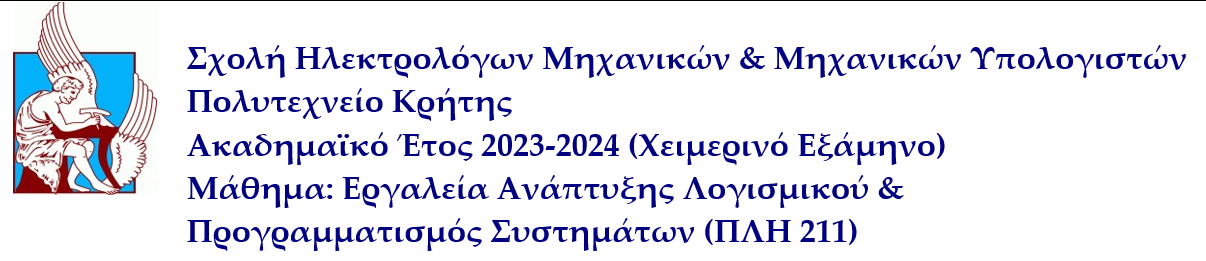

### Στοιχεία Φοιτητών Ομάδας
---
#### Φοιτητής 1
##### Αριθμός Μητρώου:2020030116
##### Όνοματεπώνυμο: Μεσσαριτάκης Γεώργιος
##### Phases στα οποία εργάστηκε: Development , Refactoring , Unit Testing
---
#### Φοιτητής 2
##### Αριθμός Μητρώου:2020030055
##### Όνοματεπώνυμο: Τσικριτζάκης Γεώργιος-Μάριος
##### Phases στα οποία εργάστηκε: Development , Profiling , Refactoring
---
#### Φοιτητής 3
##### Αριθμός Μητρώου:2020030137
##### Όνοματεπώνυμο: Κουτσοβασίλης Βασίλης
##### Phases στα οποία εργάστηκε: Development , Logging , Refactoring
---



# Εργασία 1 - Θέμα: Ανάπτυξη Λογισμικού Aggregative News Analyzer

---
⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰
# ΔΕΝ προχωράμε παρακάτω σε αυτό το notebook αν δεν έχουμε διαβάσει και είμαστε έτοιμοι να εφαρμόσουμε ακριβώς τις οδηγίες που διανέμονται μαζί με αυτή την εργασία στο PLH211_Project1_2023_2024_Directions.docx.
---
⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰

<font color='red'> Στα πλαίσια της εργασίας δεν μπορείτε να υποθέσετε ότι τα news και άρα τα αρχεία που σας δίδονται δεν αλλάζουν ποτέ. Το αρχείο με τα news θεωρείται μεταβλητό καθώς σε ένα πραγματικό σενάριο τα news ανανεώνονται σε τακτά χρονικά διαστήματα. Άρα δεν μπορείτε να προ-υπολογίσετε το Jaccard Index και όσα άλλα ζητούνται μόνο μια φορά και να τα σώσετε μια μόνο φορά σε αρχείο.</font>  

# Development Phase

## ⏩ Κώδικας Development Phase
Γράψτε στο παρακάτω code cell όλο τον κώδικα που υλοποιεί τον Aggregative News Analyzer σας.

###Πρίν την εκτέλεση του προγράμματος απαιτείται σύνδεση στο Drive για εντοπισμό των αρχείων της άσκησης

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%file aggregate_news_analyzer.py
import sys
import glob
import os
import operator
import json
from openpyxl import Workbook
from openpyxl.styles import Font


#path_to_files = "dataforproject1"
path_to_files = "/content/drive/MyDrive/filesforplh211"
term_to_stem_dict_instance = None

def process_input(user_input, jaccard_indices , list_of_data):
    '''
        Routine to process the user input,and execute the given command.
        @param0 the user input-command
        @param1 the jaccard indices computed in the beggining
        @param2 the list of data files.
    '''

    if user_input == '':
        print("Error: Missing input.")
        return None

    # split the user input into a list of arguments.
    args = user_input.split(" ") # space separated
    command = args[0]

    # 1.Show top <k> relevant stems for category
    if command == '@':

        if len(args) < 3:
            print("Error: Missing arguments for category relevance.")
        else:
            category = args[1]
            k = int(args[2])
            term_to_stem_map = get_term_to_stem_dict()

            # Get the relevant stem-category pairs with Jaccard Indexes
            dict_of_relevant_terms_with_indices = {}

            for key,value in jaccard_indices.items():
                if key[0] == category:
                    dict_of_relevant_terms_with_indices[key[1]] = value

            # Sort the stem-category pairs by Jaccard Index
            sorted_dict = dict(sorted( dict_of_relevant_terms_with_indices.items(), key=operator.itemgetter(1),reverse = True) )

            #get the k first terms in the dictionary
            term_list = list(sorted_dict.keys())[:k]

            print(f"Top {k} stems for category '{category}':")
            for term_id in term_list:
                print(term_to_stem_map[str(term_id)])


    # 2.Show top <k> relevant categories for stem
    elif command == '#':
        # Display categories most relevant to a stem
        if len(args) < 3:
            print("Error: Missing arguments for stem relevance.")
        else:
            stem = args[1]
            k = int(args[2])

            term_to_stem_map = get_term_to_stem_dict()

            # Get the relevant stem-category pairs with Jaccard Indexes
            term = 0

            for term_id in term_to_stem_map.keys():
                if term_to_stem_map[term_id] == stem:
                    term = term_id
                    break


            term_to_category = {}

            for key, value in jaccard_indices.items():
                if key[1] == term:
                    term_to_category[key[0]] = value

            sorted_dict = dict(sorted( term_to_category.items(), key=operator.itemgetter(1) , reverse = True) )

            for index, category in enumerate(sorted_dict):
                if(index >= k):
                    break
                print(category)



    # 3.Show top <k> stem-category pairs with Jaccard Indexes
    elif command == '$':
        # Display the Jaccard Index for a stem-category pair
        if len(args) < 3:
            print("Error: Missing arguments for Jaccard Index.")
        else:
            show_jaccard_index(args[1], args[2], jaccard_indices)

    # 4.Save all stem-category pairs with Jaccard Indexes to a file
    elif command.startswith('*'):
       # Save all stem-category pairs with Jaccard Indexes to a file
        file = args[1].strip().split('.')
        filename = file[0]
        filetype = file[1]
        if filetype in ['json', 'xlsx']:
            save_all_stem_category_pairs(filename, filetype, jaccard_indices)
        else:
            print("Error: Unsupported file type. Please use 'json' or 'xlsx'.")

    # 5.Show all stem-category pairs with Jaccard Indexes
    elif command in ['P', 'C']:
        # Depending on the command, display either all stems or categories included in a document
        if len(args) < 3:
            print("Error: Missing arguments for document contents.")

        else:
            option = args[2]
            if option not in ('-t' , '-c'):
                print(f"Unknown option for {command} command!")
                return

            doc_id = args[1]
            if option == '-t':
                # Show all relevant term_ids with this doc_id
                show_relevant_stems_for_doc(command, doc_id , list_of_data)

            else: #option is '-c'
                #Show all relevant categories of this doc_id
                show_relevant_categories_for_doc( command , doc_id )
    else:
        print("Error: Unknown command.")


def show_jaccard_index(stem, category, jaccard_indices):
    '''
        Print the jaccard index for the stem and category given.
        @param0 stem
        @param1 category
        @param2 all the jaccard indices computed in previous steps.
    '''
    term_to_stem_map = get_term_to_stem_dict()

    # Get the relevant stem-category pairs with Jaccard Indexes
    term = ""

    for term_id in term_to_stem_map.keys():
        if term_to_stem_map[term_id] == stem:
            term = term_id
            break
    else: # given stem does not exist!Wrong input
        print("No jaccard index for the given stem!")
        return None

    print(jaccard_indices[(category, term)])


def read_map(file_path):
    '''
        Read the stem to term_id mapping from the file.
        @param0 the file path.
        Returns a dictionary with term to stem mapping {term_id : stem}
    '''
    term_id_to_stem = {}
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as map_file:
        # Skip the initial lines that don't contain term ID and stem mappings
        for _ in range(8):  # Adjust the number based on how many lines to skip
            next(map_file)
        # Read the rest of the file
        for line in map_file:
            try:
                stem , term_id , _ = line.strip().split()
                term_id_to_stem[term_id] = stem
            except ValueError:
                # Handle lines that don't conform to the expected format
                continue
    return term_id_to_stem

def get_term_to_stem_dict() :
    """
        Get the term-to-stem dictionary instance.
        This function is based on singleton design pattern.
    """
    # Use global keyword to change the global variable
    global term_to_stem_dict_instance

    if term_to_stem_dict_instance is None:
        map_file_path = path_to_files + "/stem.termid.idf.map.txt"
        term_to_stem_dict_instance = read_map(map_file_path)

    return term_to_stem_dict_instance


def compute_jaccard_index(doc_t, doc_c):
    """Compute the jaccard index.
        @param 0 , set of document IDs that have 'term id' inside
        @param 1 , set of document IDs that have 'category id' inside
    """
    intersection = doc_t.intersection(doc_c)
    intersection_cardinality = len(intersection)

    union_cardinality = len(doc_t) + len(doc_c) - intersection_cardinality

    return ( intersection_cardinality / union_cardinality )



def save_all_stem_category_pairs(filename, filetype, jaccard_indices):
    '''
        Save all jaccard indices to a file(json/xlsx).
        @param0 the filename of the file to read.
        @param1 the filetype(json/xslsx)
        @param2 all the jaccard indices computed on previous steps.
    '''
    term_to_stem_map = get_term_to_stem_dict()

    if filetype == "json":
        with open(f"{filename}.json", "w") as json_file:
            dic = {}
            for key, value in jaccard_indices.items():
                if key[1] in term_to_stem_map.keys():
                    stem = term_to_stem_map[key[1]]
                    dic[stem+" "+key[0]] = value

            json_jaccard = json.dumps(dic, ensure_ascii = False)
            json_file.write(json_jaccard)
    else:
        wb = Workbook()
        ws = wb.active

        # Add headers
        stem_col = ws.cell(row=1, column=1)
        category_col = ws.cell(row=1, column=2)
        jaccard_col = ws.cell(row=1, column=3)

        stem_col.value = "Stem"
        stem_col.font = Font(bold = True)
        category_col.value = "Category"
        category_col.font = Font(bold = True)
        jaccard_col.value = "Jaccard Index"
        jaccard_col.font = Font(bold = True)

        # Add data rows
        i = 2
        col = 0
        for key, value in jaccard_indices.items():
            if i == 1048576:
                i = 1
                col += 3
            if key[1] in term_to_stem_map.keys():
                ws.cell(row=i, column=1 + col).value = term_to_stem_map[key[1]]
                ws.cell(row=i, column=2 + col).value = key[0]
                ws.cell(row=i, column=3 + col).value = value
                i += 1

        # Save the workbook
        wb.save(f"{filename}.xlsx")

def show_relevant_stems_for_doc (command , doc_id , list_of_data):
    '''
        Show or Count all the relevant stems this doc_id contains.
        @param0 The command P/C for printing or counting respectively.
        @param1 The doc id to find all his relevant terms.
        @param2 The list of data.Needed so we dont have to read again all the test files.
    '''
    relevant_terms = set()
    for dic in list_of_data:
      if doc_id in dic.keys():
          relevant_terms = relevant_terms.union( dic[doc_id] ) # append the set of term_ids

    # relevant_terms contains all relevant term_ids to this document

    id_to_stem_map = get_term_to_stem_dict()

    if command == 'P':
        for term_id in relevant_terms:
            print( id_to_stem_map[term_id] )
    else: #command = 'C'
        print(f"Document:{doc_id} has {len(relevant_terms)} relevant terms. ")


def show_relevant_categories_for_doc (command , doc):
    '''
        Show or Count all the relevant categories this doc_id contains.
        @param0 The command P/C for printing or counting respectively.
        @param1 The doc id to find all his relevant categories.
    '''
    relevant_categories_for_doc = {}
    with open( path_to_files + "/rcv1-v2.topics.qrels.txt", 'r') as file:
        for line in file:
            categ, doc_id, _ = line.strip().split()
            if doc_id not in relevant_categories_for_doc.keys():
                relevant_categories_for_doc[doc_id] = set()
            relevant_categories_for_doc[doc_id].add(categ) # add the relevant category to this document

    if command == 'P' :
        for cat in relevant_categories_for_doc[doc] :
            print(cat)
    else: # command = 'C'
        print(f"Document:{doc} has {len(relevant_categories_for_doc[doc])} categories. ")


def print_menu():
    """Prints all the available commands."""

    print("\nMenu:")
    print("@ <category> <k> - Show top <k> relevant stems for category <category>")
    print("# <stem> <k> - Show top <k> relevant categories for stem <stem>")
    print("$ <stem> <category> - Show the Jaccard Index for stem <stem> and category <category>")
    print("* <filename>.<filetype> - Save all stem-category pairs with Jaccard Indexes to a text file")
    print("P <did> -c|-t - Show all the categories of the doc_id or all the stems that doc_id contains respectively")
    print("C <did> -c|-t - Count all the categories of the doc_id or all the stems that doc_id contains respectively")
    print("To exit, type 'exit'")

def read_data(file_path):
    '''
        Read a test file in the given file path
        @param0 the file path
        Returns a dictionary {doc_id : {term_ids} }
    '''
    data = {}
    with open(file_path, 'r') as file:
        for line in file:
            doc_id, term_ids = process_line(line)
            data[doc_id] = term_ids

    return data


def process_line(line):
    '''
        Process the line of the test file.Keep only the indices we care about(doc_id -> term_ids)
        @param0 the line to process.
        Returns a dictionary with the mapping {doc_id : {term_ids} }
    '''
    parts = line.split()
    record_id = parts[0]
    term_ids = {parts[i].split(':')[0] for i in range(1, len(parts), 2)}
    return record_id, term_ids


def read_test_files():
    """ Read test data files.
        Returns a list containing dictionaries ,
        each one for one data file
    """

    #file_pattern = os.path.join(path_to_files, 'lyrl2004_vectors_test_pt*.dat.txt')
    file_pattern = os.path.join(path_to_files, 'lyrl2004_vectors_test_pt1.dat.txt')

    list_of_data = [] # list of dictionaries
    for file_path in glob.glob(file_pattern):
        list_of_data.append( read_data(file_path) )

    return list_of_data

def compute_doc_c():
    """ Compute DOC(C)
        How many doc_ids has each category.
        Returns a dictionary {category : {doc_ids}}
    """

    qrels = {}
    with open( path_to_files + "/rcv1-v2.topics.qrels.txt", 'r') as file:
        for line in file:
            categ, doc_id, _ = line.strip().split()
            # if the category does not exist create it.
            if categ not in qrels.keys():
                qrels[categ] = set()

            qrels[categ].add(doc_id)

    return qrels

def compute_doc_t(list_of_data):
    """ Compute doc_t
        How many doc_ids has each term_id.
        @param0 the test data(doc_id -> term_ids)
        Returns a dictionary {term_id : {doc_ids}}
    """

    doc_t = {} # how many doc_ids has each term_id

    for dict in list_of_data:
        for key,value in dict.items():
            for term_id in value:
                if term_id not in doc_t.keys():
                    doc_t[term_id] = set()
                doc_t[term_id].add(key)
    return doc_t


def main():

    list_of_data = read_test_files() # list of dictionaries. : { doc_id : {term_ids} }

    # Read qrels file - compute DOC(C) , how many doc_ids has each category { category : {doc_ids} }
    doc_c = compute_doc_c()

    # Compute DOC(T) , how many doc_ids has each term_id : { term_id : {doc_ids} }
    doc_t = compute_doc_t(list_of_data)

    # compute all jaccard indices
    jaccard_indices = {}
    for category in doc_c.keys():
        for term_id in doc_t.keys():
            jaccard_indices[ (category,term_id) ] = compute_jaccard_index( doc_t[term_id] , doc_c[category] )


    while True:
        print_menu()
        user_input = input("Enter your command: ").strip() # Remove leading and trailing whitespace
        if user_input == 'exit':
            break
        process_input(user_input, jaccard_indices , list_of_data)


if __name__ == "__main__":
    sys.exit(main())

Writing aggregate_news_analyzer.py


In [ ]:
import aggregate_news_analyzer

if __name__ == "__main__":
    #aggregate_news_analyzer.print_menu()
    aggregate_news_analyzer.main()  # Call the main method from the module



Menu:
@ <category> <k> - Show top <k> relevant stems for category <category>
# <stem> <k> - Show top <k> relevant categories for stem <stem>
$ <stem> <category> - Show the Jaccard Index for stem <stem> and category <category>
* <filename>.<filetype> - Save all stem-category pairs with Jaccard Indexes to a text file
P <did> -c|-t - Show all the categories of the doc_id or all the stems that doc_id contains respectively
C <did> -c|-t - Count all the categories of the doc_id or all the stems that doc_id contains respectively
To exit, type 'exit'
Enter your command: @ E11 5
Top 5 stems for category 'E11':
growth
gdp
econom
gross
domest

Menu:
@ <category> <k> - Show top <k> relevant stems for category <category>
# <stem> <k> - Show top <k> relevant categories for stem <stem>
$ <stem> <category> - Show the Jaccard Index for stem <stem> and category <category>
* <filename>.<filetype> - Save all stem-category pairs with Jaccard Indexes to a text file
P <did> -c|-t - Show all the categories o

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Developement Phase
Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Development Phase στο προηγούμενο code cell (H τεκμηρίωση βαθμολογείται).

**Στην πρώτη φάση της άσκησης κληθήκαμε να δημιουργήσουμε ένα πρόγραμμα το οποίο επεξεργάζεται τα δεδομένα που μας δόθηκαν και προσφέρει ένα menu με τις παρακάτω υπηρεσίες:**

* `@ <category> <k> - Show top <k> relevant stems for category <category>`
* `# <stem> <k> - Show top <k> relevant categories for stem <stem>`
* `$ <stem> <category> - Show the Jaccard Index for stem <stem> and category <category>`
* `* <filename>.<filetype> - Save all stem-category pairs with Jaccard Indexes to a text file`
* `P <did> -c|-t - Show all the categories of the doc_id or all the stems that doc_id contains respectively`
* `C <did> -c|-t - Count all the categories of the doc_id or all the stems that doc_id contains respectively`
* `To exit, type 'exit'`

Αρχικά , διαβάζουμε τα test αρχεία με τη χρήση των συναρτήσεων `read_test_files`
η οποία καλεί την `read_data` για το διάβασμα του κάθε αρχείου και μετά για το διάβασμα και την επεξεργασία της κάθε γραμμής στα `lyrl2004_vectors_test_pt*.txt` αρχεία καλείται η `process_line`.Έτσι , φτιάχνεται μια λίστα απο λεξικά της μορφής [... , {document_id : (term_ids)}, ...]. Στη συνέχεια , για τον υπολογισμό των `doc_c` καλείται η συνάρτηση `compute_doc_c` η οποία διαβάζει το αρχείο `rcv1-v2.topics.qrels.txt` και επεξεργάζεται την κάθε γραμμή επιστρέφοντας ένα λεξικό με μορφή {category : set(doc_ids)} , αντίστοιχα υπολογίζουμε το `doc_t` διαβάζοντας όμως από τη λίστα που πήραμε προηγουμένως με τη `read_test_files` δημιουργώντας έτσι ένα λεξικό με μορφή {term_id : (doc_ids)}.Τέλος , πριν δείξουμε το μενού επιλογών στον χρήστη υπολογίζουμε τα jaccard indexes παίρνοντας στην ουσία το καρτεσιανό γινόμενο μεταξύ των doc_c και doc_t.Aυτό γίνεται καλώντας την συνάρτηση `compute_jaccard_index` για κάθε ένα ζευγάρι (category,term_id).Στη συνέχεια ζητείται απο τον χρήστη είσοδος η οποία μεταβιβάζεται στην `process_input` όπου ανάλογα την είσοδο εκτελείται και η κατάλληλη λειτουργικότητα όπως παρουσιάστηκε και παραπάνω.

### ▶ Περίπτωση που η εντολή περιέχει '@' :
Σε αυτή την περίπτωση , ανάλογα με το category που εισήγαγε ο χρήστης βρίσκουμε αρχικά τα `top κ` πιο σχετισμένα ,βάση jaccard indexes, και στη συνέχεια με τη χρήση της `get_term_to_stem_dict` αντιστοιχίζουμε με 1-1 τα terms που βρήκαμε με τα αντίστοιχα , μοναδικά για το καθένα , stems . Η συγκεκριμένη συνάρτηση υλοποιεί το Singleton Design Pattern δημιουργώντας ένα μοναδικό για όλο το πρόγραμμα στιγμιότυπο του.Αυτό γίνεται καθώς καλείται από πολλά σημεία του κώδικα μας και θα ήταν ασύμφορο χρονικά και σε κατανάλωση μνήμης να δημιουργεί συνεχώς διαφορετικά στιγμιότυπα.

### ▶ Περίπτωση που η εντολή περιέχει '#' :
Αυτή τη φορά βάση stem , ψάχνουμε και βρίσκουμε το term_id και βάση jaccard index βρίσκουμε τις `top κ` πιο σχετικές κατηγορίες.


### ▶ Περίπτωση που η εντολή περιέχει '$` :
Σε αυτή τη περίπτωση καλούμε τη συνάρτηση `show_jaccard_index` η οποία αναλαμβάνει να βρεί απο την ήδη υπολογισμένη λίστα το ζευγάρι (category,term_id)
τυπώνει στην οθόνη την τιμή του jaccard index για το συγκεκριμένο ζεύγος.

### ▶ Περίπτωση που η εντολή περιέχει '*` :
Εδώ , αφού επεξεργαστούμε την είσοδο του χρήστη , καλούμε την συνάρτηση `save_all_stem_category_pairs` η οποία αντίστοιχα με το είδος του αρχείου που θέλουμε να σώσουμε τα δεδομένα (excel ή json) χρησιμοποιεί και διαφορετικές συναρτήσεις καταλήγοντας στο να αποθηκεύσει στο κατάλληλο αρχείο όλα το λεξικό των jaccard index.

**Σε περίπτωση που ο χρήστης ζητήσει τα δεδομένα του να γραφτούν σε αρχείο excel ο χρόνος υπολογίζεται περίπου στα 15-20 λεπτά.**

### ▶ Περίπτωση που η εντολή περιέχει '<document id> -t`:
Εδώ καλείται η `show_relevant_stems_for_doc` η οποία στην περίπτωση που η εντολή έχει τη μορφή `P <document id> -t` ,  αναλαμβάνει να τυπώσει τα relevant term_ids που έχει το συγκεκριμένο document με document id.Ενώ , εάν η εντολή έχει τη μορφή `C <document id> -t` τυπώνει την ποσότητα των προηγουμένων.

### ▶ Περίπτωση που η εντολή περιέχει '<document id> -c`:
Εδώ καλείται η `show_relevant_categories_for_doc` η οποία στην περίπτωση που η εντολή έχει τη μορφή `P <document id> -c` , αναλαμβάνει να τυπώσει τα relevant categories που έχει το συγκεκριμένο document με document id.Ενώ , εάν η εντολή έχει τη μορφή `C <document id> -c` τυπώνει την ποσότητα των προηγουμένων.

**ΣΗΜΕΙΩΣΗ**

Πρίν την εκτέλεση του κώδικα του development phase είναι απαραίτητο να τοποθετηθεί το σωστό path για τα αρχεία της άσκησης στην global μεταβλητή `path_to_files`



# Logging Phase


## ⏩ Κώδικας Logging Phase
Γράψτε στο παρακάτω code cell όλο τον κώδικα που φτιάχνει το myeditorlog.conf αρχείο με το configuration (loggers, handlers, formatters) του logger σας.

`format=%(asctime)s - %(name)s - %(levelname)s - %(message)s `

In [3]:
%%file myeditorlog.conf
[loggers]
keys=root

[handlers]
keys=file

[formatters]
keys=fileForm

[formatter_fileForm]
format=%(asctime)s - %(name)s - %(levelname)s - %(message)s

[handler_file]
class=FileHandler
level=INFO
formatter=fileForm
propagate=0
args=('logme.txt','w')

[logger_root]
level=INFO
handlers=file

Writing myeditorlog.conf


Γράψτε στο παρακάτω code cell τον κώδικα του Aggregative News Analyzer όπως ήταν στο Developement phase ΑΛΛΑ εδώ θα έχει και εισαγωγή των κατάλληλων εντολών που δημιουργούν τα LogRecords ώστε αυτά να γράφονται σε ένα αρχείο logme.txt .

In [4]:
import sys
import glob
import os
import operator
import json
from openpyxl import Workbook
from openpyxl.styles import Font
import logging
import logging.config


path_to_files = "/content/drive/MyDrive/filesforplh211"
term_to_stem_dict_instance = None

def process_input(user_input, jaccard_indices , list_of_data):

    if user_input == '':
        print("Error: Missing input.")
        return None

    # split the user input into a list of arguments.
    args = user_input.split(" ") # space separated
    command = args[0]

    # 1.Show top <k> relevant stems for category
    if command == '@':

        if len(args) < 3:
            print("Error: Missing arguments for category relevance.")
        else:
            category = args[1]
            k = int(args[2])
            term_to_stem_map = get_term_to_stem_dict()

            # Get the relevant stem-category pairs with Jaccard Indexes
            dict_of_relevant_terms_with_indices = {}

            for key,value in jaccard_indices.items():
                if key[0] == category:
                    dict_of_relevant_terms_with_indices[key[1]] = value

            # Sort the stem-category pairs by Jaccard Index
            sorted_dict = dict(sorted( dict_of_relevant_terms_with_indices.items(), key=operator.itemgetter(1),reverse = True) )

            #get the k first terms in the dictionary
            term_list = list(sorted_dict.keys())[:k]

            print(f"Top {k} stems for category '{category}':")
            for term_id in term_list:
                print(term_to_stem_map[str(term_id)])


    # 2.Show top <k> relevant categories for stem
    elif command == '#':
        # Display categories most relevant to a stem
        if len(args) < 3:
            print("Error: Missing arguments for stem relevance.")
        else:
            stem = args[1]
            k = int(args[2])

            term_to_stem_map = get_term_to_stem_dict()

            # Get the relevant stem-category pairs with Jaccard Indexes
            term = 0

            for term_id in term_to_stem_map.keys():
                if term_to_stem_map[term_id] == stem:
                    term = term_id
                    break


            term_to_category = {}

            for key, value in jaccard_indices.items():
                if key[1] == term:
                    term_to_category[key[0]] = value

            sorted_dict = dict(sorted( term_to_category.items(), key=operator.itemgetter(1) , reverse = True) )

            for index, category in enumerate(sorted_dict):
                if(index >= k):
                    break
                print(category)


    # 3.Show top <k> stem-category pairs with Jaccard Indexes
    elif command == '$':
        # Display the Jaccard Index for a stem-category pair
        if len(args) < 3:
            print("Error: Missing arguments for Jaccard Index.")
        else:
            show_jaccard_index(args[1], args[2], jaccard_indices)

    # 4.Save all stem-category pairs with Jaccard Indexes to a file
    elif command.startswith('*'):
        # Save all stem-category pairs with Jaccard Indexes to a file
        file = args[1].strip().split('.')
        filename = file[0]
        filetype = file[1]
        if filetype in ['json', 'xlsx']:
            save_all_stem_category_pairs(filename, filetype, jaccard_indices)
        else:
            print("Error: Unsupported file type. Please use 'json' or 'xlsx'.")

    # 5.Show all stem-category pairs with Jaccard Indexes
    elif command in ['P', 'C']:
        # Depending on the command, display either all stems or categories included in a document
        if len(args) < 3:
            print("Error: Missing arguments for document contents.")
        else:
            option = args[2]
            if option not in ('-t' , '-c'):
                print(f"Unknown option for {command} command!")
                return

            doc_id = args[1]
            if option == '-t':
                # Show all relevant term_ids with this doc_id
                show_relevant_stems_for_doc(command, doc_id , list_of_data)

            else: #option is '-c'
                #Show all relevant categories of this doc_id
                show_relevant_categories_for_doc( command , doc_id )
    else:
        print("Error: Unknown command.")


def read_qrels(file_path, category):
    """ Find all document IDs in the given qrels file that belongs to the given category. """

    document_ids = set()
    with open(file_path, 'r') as file:
        for line in file:
            categ, doc_id, _ = line.strip().split()
            if categ == category:
                document_ids.add(doc_id)

    return document_ids

def show_jaccard_index(stem, category, jaccard_indices):

    term_to_stem_map = get_term_to_stem_dict()

    # Get the relevant stem-category pairs with Jaccard Indexes
    term = ""

    for term_id in term_to_stem_map.keys():
        if term_to_stem_map[term_id] == stem:
            term = term_id
            break

    print(jaccard_indices[(category, term)])



def read_data(file_path):
    data = {}
    with open(file_path, 'r') as file:
        for line in file:
            doc_id, term_ids = process_line(line)
            data[doc_id] = term_ids

    return data


def process_line(line):
    parts = line.split()
    record_id = parts[0]
    term_ids = {parts[i].split(':')[0] for i in range(1, len(parts), 2)}
    return record_id, term_ids


def read_map(file_path):
    term_id_to_stem = {}
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as map_file:
        # Skip the initial lines that don't contain term ID and stem mappings
        for _ in range(8):  # Adjust the number based on how many lines to skip
            next(map_file)
        # Read the rest of the file
        for line in map_file:
            try:
                stem , term_id , _ = line.strip().split()
                term_id_to_stem[term_id] = stem
            except ValueError:
                # Handle lines that don't conform to the expected format
                continue
    return term_id_to_stem

def get_term_to_stem_dict() :
    """
        Get the term-to-stem dictionary instance.
        This function is based on singleton design pattern.
    """
    # Use global keyword to change the global variable
    global term_to_stem_dict_instance

    if term_to_stem_dict_instance is None:
        map_file_path = path_to_files + "/stem.termid.idf.map.txt"
        term_to_stem_dict_instance = read_map(map_file_path)

    return term_to_stem_dict_instance


def compute_jaccard_index(doc_t, doc_c):
    """Compute the jaccard index.
        @param 0 , set of document IDs that have 'term id' inside
        @param 1 , set of document IDs that have 'category id' inside
    """
    intersection = doc_t.intersection(doc_c)
    intersection_cardinality = len(intersection)

    union_cardinality = len(doc_t) + len(doc_c) - intersection_cardinality

    return ( intersection_cardinality / union_cardinality )



def save_all_stem_category_pairs(filename, filetype, jaccard_indices):

    term_to_stem_map = get_term_to_stem_dict()

    if filetype == "json":
        with open(f"{filename}.json", "w") as json_file:
            dic = {}
            for key, value in jaccard_indices.items():
                if key[1] in term_to_stem_map.keys():
                    stem = term_to_stem_map[key[1]]
                    dic[stem+" "+key[0]] = value

            json_jaccard = json.dumps(dic, ensure_ascii = False)
            json_file.write(json_jaccard)
    else:
        wb = Workbook()
        ws = wb.active

        # Add headers
        stem_col = ws.cell(row=1, column=1)
        category_col = ws.cell(row=1, column=2)
        jaccard_col = ws.cell(row=1, column=3)

        stem_col.value = "Stem"
        stem_col.font = Font(bold = True)
        category_col.value = "Category"
        category_col.font = Font(bold = True)
        jaccard_col.value = "Jaccard Index"
        jaccard_col.font = Font(bold = True)

        # Add data rows
        i = 2
        col = 0
        for key, value in jaccard_indices.items():
            if i == 1048576:
                i = 1
                col += 3
            if key[1] in term_to_stem_map.keys():
                ws.cell(row=i, column=1 + col).value = term_to_stem_map[key[1]]
                ws.cell(row=i, column=2 + col).value = key[0]
                ws.cell(row=i, column=3 + col).value = value
                i += 1

        # Save the workbook
        wb.save(f"{filename}.xlsx")

def show_relevant_stems_for_doc (command , doc_id , list_of_data):

    relevant_terms = set()
    for dic in list_of_data:
        if doc_id in dic.keys():
            relevant_terms = relevant_terms.union( dic[doc_id] ) # append the set of term_ids

    # relevant_terms contains all relevant term_ids to this document

    id_to_stem_map = get_term_to_stem_dict()

    if command == 'P':
        for term_id in relevant_terms:
            print( id_to_stem_map[term_id] )
    else: #command = 'C'
        print(f"Document:{doc_id} has {len(relevant_terms)} relevant terms. ")


def show_relevant_categories_for_doc (command , doc):

    relevant_categories_for_doc = {}
    with open( path_to_files + "/rcv1-v2.topics.qrels.txt", 'r') as file:
        for line in file:
            categ, doc_id, _ = line.strip().split()
            if doc_id not in relevant_categories_for_doc.keys():
                relevant_categories_for_doc[doc_id] = set()
            relevant_categories_for_doc[doc_id].add(categ) # add the relevant category to this document

    if command == 'P' :
        for cat in relevant_categories_for_doc[doc] :
            print(cat)
    else: # command = 'C'
        print(f"Document:{doc} has {len(relevant_categories_for_doc[doc])} categories. ")


def print_menu():
    """Prints all the available commands."""

    print("\nMenu:")
    print("@ <category> <k> - Show top <k> relevant stems for category <category>")
    print("# <stem> <k> - Show top <k> relevant categories for stem <stem>")
    print("$ <stem> <category> - Show the Jaccard Index for stem <stem> and category <category>")
    print("* <filename>.<filetype> - Save all stem-category pairs with Jaccard Indexes to a text file")
    print("P <did> -c|-t - Show all the categories of the doc_id or all the stems that doc_id contains respectively")
    print("C <did> -c|-t - Count all the categories of the doc_id or all the stems that doc_id contains respectively")
    print("To exit, type 'exit'")


def read_test_files():
    """ Read test data files."""

    file_pattern = os.path.join(path_to_files, 'lyrl2004_vectors_test_pt1.dat.txt')

    list_of_data = [] # list of dictionaries
    for file_path in glob.glob(file_pattern):
        list_of_data.append( read_data(file_path) )

    return list_of_data

def compute_doc_c():
    """ Compute DOC(C) """

    qrels = {}
    with open( path_to_files + "/rcv1-v2.topics.qrels.txt", 'r') as file:
        for line in file:
            categ, doc_id, _ = line.strip().split()
            # if the category does not exist create it.
            if categ not in qrels.keys():
                qrels[categ] = set()

            qrels[categ].add(doc_id)

    return qrels

def compute_doc_t(list_of_data):
    """ Compute doc_t"""

    doc_t = {} # how many doc_ids has each term_id

    for dict in list_of_data:
        for key,value in dict.items():
            for term_id in value:
                if term_id not in doc_t.keys():
                    doc_t[term_id] = set()
                doc_t[term_id].add(key)
    return doc_t


def main():
    # load the .conf file
    logging.config.fileConfig(fname = 'myeditorlog.conf', disable_existing_loggers=False)

    logger = logging.getLogger(__name__)

    list_of_data = read_test_files() # list of dictionaries

    # Read qrels file - compute DOC(C) , how many doc_ids has each category
    doc_c = compute_doc_c()

    # Compute DOC(T)
    doc_t = compute_doc_t(list_of_data)

    # compute all jaccard indices
    jaccard_indices = {}
    for category in doc_c.keys():
        for term_id in doc_t.keys():
            jaccard_indices[ (category,term_id) ] = compute_jaccard_index( doc_t[term_id] , doc_c[category] )

    while True:
        print_menu()
        user_input = input("Enter your command: ").strip() # Remove leading and trailing whitespace

        # log the command of the user
        logger.info(f'User entered command: {user_input}.')

        if user_input == 'exit':
            break
        process_input(user_input, jaccard_indices , list_of_data)


if __name__ == "__main__":
    sys.exit(main())


Menu:
@ <category> <k> - Show top <k> relevant stems for category <category>
# <stem> <k> - Show top <k> relevant categories for stem <stem>
$ <stem> <category> - Show the Jaccard Index for stem <stem> and category <category>
* <filename>.<filetype> - Save all stem-category pairs with Jaccard Indexes to a text file
P <did> -c|-t - Show all the categories of the doc_id or all the stems that doc_id contains respectively
C <did> -c|-t - Count all the categories of the doc_id or all the stems that doc_id contains respectively
To exit, type 'exit'
Enter your command: # yasuo 5
M142
C12
E11
E12
M132

Menu:
@ <category> <k> - Show top <k> relevant stems for category <category>
# <stem> <k> - Show top <k> relevant categories for stem <stem>
$ <stem> <category> - Show the Jaccard Index for stem <stem> and category <category>
* <filename>.<filetype> - Save all stem-category pairs with Jaccard Indexes to a text file
P <did> -c|-t - Show all the categories of the doc_id or all the stems that doc_

SystemExit: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Logging Phase
Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Logging Phase στο προηγούμενο code cell (H τεκμηρίωση βαθμολογείται).

Αρχικά φτιάξαμε ένα `.conf` αρχείο μέσα στο οποίο παραμετροποιήσαμε τον root logger. Όπως φαίνεται και μέσα στο αρχείο χρησιμοποιούμε έναν logger τον `root`, έναν handler που τον ονομάσαμε file και είναι τύπου `FileHandler`, επιπέδου `INFO` ώστε να γράφει στο αρχείο `logme.txt`, καθώς και έναν formatter ονόματι fileForm o οποίος έχει το επιθυμητό format για το logRecord. Στην συνέχεια μέσα στον κώδικα που παράχθηκε στο development phase προσθέσαμε και κώδικα για να εξυπηρετήσουμε τις λειτουργίες του logging. Πιο συγκεκριμένα αφού κάναμε import της απαραίτητες βιβλιοθήκες logging στην `main` μέθοδο χρησιμοποιήσαμε αρχικά την `fileConfig()` μέθοδο για να φορτώσουμε το config file και στην συνέχεια δημιουργήσαμε ένα logger object περνώντας την παράμετρο `__name__`. Τέλος χρησιμοποιούμε την μέθοδο `logger.info()` μετά από κάθε command του χρήστη ώστε να γραφεί αυτό στο αρχείο `logme.txt`. Εφόσον έχει χρησιμοποιηθεί το σύμβολο `w` στο πεδίο `args` του file handler είναι σίγουρο ότι θα γράφουμε κάθε φορά στο αρχείο μόνο τις εντολές που έβαλε o τελευταίος χρήστης του προγράμματος, αφού κάθε φορά που θα τρέχει κάποιος χρήστης το πρόγραμμα το αρχείο `logme.txt` θα πανωγραφεί με τα νέα `logRecords`.  

# Profiling Phase

## ⏩ Κώδικας Profiling Phase

Γράψτε σε ένα ή περισσότερο code cells τον κώδικα του Aggregative News Analyzer με τις εντολές που προσθέσατε για profiling.

*Υπόδειξη: Θα σας είναι πιο εύκολο να το κάνετε αυτό συμβουλευόμενοι την ενότητα Beyond Interactive Notebooks - Profiling in IDEs της αντίστοιχης διάλεξης και το line profiler ή/και το cProfiler, memory_profiler. Αυτή τη φάση μπορείτε και συστήνεται να τη δουλέψετε σε loops με το refactoring. Δλδ μπορείτε εδώ να δοκιμάσετε εναλλακτικές υλοποιήσεις, να μετρήσετε την απόδοσή τους ώστε να επιχειρηματολογήσετε στην επόμενη φάση για το πως κάνατε refactor των κώδικά σας.*

### ⏩⏩ Dependencies:

In [ ]:
!pip install line_profiler
!pip install memory_profiler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 714.8/714.8 kB 7.2 MB/s eta 0:00:00


In [ ]:
%load_ext line_profiler
%load_ext memory_profiler

### ⏩⏩ Imports:

In [ ]:
import sys
import glob
import os
import operator
import json
from collections import defaultdict
from openpyxl import Workbook
from openpyxl.styles import Font


Παρακάτω θα χρησιμοποιηθεί η `%lprun` και η `%memit` για τις περισσότερες υπορουτίνες του κώδικα ώστε να δούμε που υπάρχουν τα major bottlenecks και που απαιτείται να διορθωθεί ο κώδικας.

Σε περίπτωση που το παρακάτω τεστ δώσει `IOPub data rate exceeded` Error, τρέξτε το παρακάτω:

In [ ]:
from IPython.core.display import display, HTML

# Set a higher IOPub data rate limit (in bytes/sec)
# Change the value as needed
limit = 10000000  # for example, setting it to 10MB/s
display(HTML("<script>Jupyter.notebook.kernel.execute('config.NotebookApp.iopub_data_rate_limit = {}')</script>".format(limit)))

#### ⏩⏩⏩ `read_test_files` Profiling:

In [ ]:
from aggregate_news_analyzer import read_test_files

# Note that %lprun -f read_test_files does not work!First specify the function and then call it with the certain parameters

%lprun -f read_test_files read_test_files()

**Η παραπάνω υλοποίηση ολοκληρώνεται μετά από συνολικά 15.3837 δευτερόλεπτα.Εφόσον , η λίστα που είχαμε δεν πρόκεται να μεταβληθεί στο μέλλον , με generator δημιουργήσαμε tuple αντί αυτού.Η υλοποίηση αυτή κατα μέσο όρο πιάνει 13.2902**

In [ ]:
def read_test_files():
    """ Read test data files."""
    file_pattern = os.path.join(path_to_files, 'lyrl2004_vectors_test_pt1.dat.txt')

    list_of_data = tuple((read_data(file_path) for file_path in glob.glob(file_pattern)))

    return list_of_data

In [ ]:
from aggregate_news_analyzer import path_to_files,read_data

%lprun -f read_test_files read_test_files()

Δοκιμάσαμε αντί tuple να χρησιμοποιήσουμε λίστα με ικανοποιητικά αποτελέσματα τα οποία όμως δεν ξεπερνάνε αυτά της υλοποίσης με tuple

In [ ]:
def read_test_files():
    """ Read test data files."""
    file_pattern = os.path.join(path_to_files, 'lyrl2004_vectors_test_pt1.dat.txt')

    list_of_data = [read_data(file_path) for file_path in glob.glob(file_pattern)]

    return list_of_data

In [ ]:
%lprun -f read_test_files read_test_files()

**Μετά την αλλαγή που κάναμε τρέξαμε το παραπάνω test 10 φορές και λάβαμε τον μέσο όρο των μετρήσεων ως προς το χρόνο και παρατηρούμε μια μείωση αυτού της τάξης του 16% , καθώς πλέον ολοκληρώνεται σε 11.3211 κατά μέσο όρο.**

Παρατηρούμε πως το 100% του χρόνου το καταναλώνει το loop με το
`list_of_data.append( read_data(file_path) )` , συνεπώς θα ελέγξουμε εκτενέστερα την συνάρτηση αυτήν και τις υποσυναρτήσεις της.

In [ ]:
from aggregate_news_analyzer import read_data

%lprun -f read_data read_data("/content/drive/MyDrive/filesforplh211/lyrl2004_vectors_test_pt1.dat.txt")

Μπορούμε να αντικαταστήσουμε το απλό loop της `read_data` που εσωτερικά καλεί την `process_line` με dictionary comprehension που εσωτερικά κάνει iterate πάνω στα processed lines.To παρακάτω δίνει μία σημαντική βελτίωση της τάξης του 20-30% καθώς απο:                                            
    14.0933s -> 10.3959s

In [ ]:
def read_data(file_path):
    with open(file_path, 'r') as file:
        return {doc_id: term_ids for doc_id, term_ids in (process_line(line) for line in file)}

In [ ]:
from aggregate_news_analyzer import process_line

%lprun -f read_data read_data("/content/drive/MyDrive/filesforplh211/lyrl2004_vectors_test_pt1.dat.txt")

Παρατηρούμε πως το 90% του χρόνου το καταναλώνει η `process_line(line)` , συνεπώς θα ελέγξουμε εκτενέστερα την συνάρτηση αυτήν για να βρούμε τις μαύρες τρύπες της.


In [ ]:
! head -1 /content/drive/MyDrive/filesforplh211/lyrl2004_vectors_test_pt1.dat.txt

In [ ]:
from aggregate_news_analyzer import process_line

first_line = "226739  274:0.202582682548721 5045:0.0670981612122457 5051:0.284355329887589 6622:0.205147176924681 6626:0.117848795429683 6691:0.0942965479130347 7119:0.0384312477652938 7633:0.148672271771316 8562:0.0684213395724658 9855:0.166060061423281 10232:0.168726673812133 11516:0.25266184708198 14057:0.139169976915967 14143:0.0604774228574716 19447:0.0454500884764796 23300:0.308053643082997 24892:0.0551892023476974 27017:0.101967412765911 28211:0.217553185260237 28747:0.070062069687768 29685:0.106450883630066 29793:0.0359232076929684 30549:0.178466069758836 31219:0.171373384168174 31576:0.0861953419740975 32919:0.168085083049846 33330:0.150073091721802 33718:0.244234292426081 34910:0.0362918855942215 35410:0.111538633156898 35414:0.217553185260237 35879:0.205147176924681 36638:0.0738711758057536 36765:0.133131990795911 42841:0.0371713337185607 42936:0.0736323289151816 43003:0.231328997155902 43950:0.127168016772662 44546:0.112590147623065 44652:0.211515769382519 46097:0.111745325386202 46099:0.100356688435027 46545:0.0202101693727439"
%lprun -f process_line process_line(first_line)

In [ ]:
def process_line(line):
    # Assuming each part is separated by a single space for efficiency.
    parts = line.split(' ')
    record_id = parts[0]
    # Use slicing to get every other part starting from index 1.
    term_ids = {part.split(':')[0] for part in parts[1::2]}
    return record_id, term_ids

In [ ]:
def process_line(line):
    # Assuming each part is separated by a single space for efficiency.
    parts = line.split(' ')
    record_id = parts[0]
    # Use slicing to get every other part starting from index 1.
    term_ids = tuple((part.split(':')[0] for part in parts[1::2]))
    return record_id, term_ids

In [ ]:
%lprun -f process_line process_line(first_line)

**Παραπάνω , δοκιμάσαμε διάφορες παραλαγές και αλλαγές στον κωδικά μας , χωρίς να παρατηρήσουμε ειδοποιούς διαφορές μεταξύ αυτών . Όμως , εφόσον τα δεδομένα μας είναι στατικά και αμετάβλητα θεωρείται καταλληλότερο να είναι με τη μορφή tuple.(4.2882e-05->3.265e-05secs)**

Παρατηρούμε πως το 70% του χρόνου το καταναλώνει η
`{parts[i].split(':')[0] for i in range(1, len(parts), 2)}` , συνεπώς θα προσπαθήσουμε να βελτιώσουμε τον χρόνο αυτής της εντολής κυρίως.
Η εντολή `line.split()` καταναλώνει το 26% του χρόνου, αλλά δεν μπορεί να βελτιστοποιηθεί περαιτέρω καθώς είναι built in function.


#### ⏩⏩⏩ `compute_doc_c` profiling :

In [ ]:
from aggregate_news_analyzer import compute_doc_c


%lprun -f compute_doc_c compute_doc_c()

In [ ]:
def compute_doc_c():
    """ Compute DOC(C) """

    # Use defaultdict to automatically create a new set for new categories
    qrels = defaultdict(set)

    with open(path_to_files + "/rcv1-v2.topics.qrels.txt", 'r') as file:
        for line in file:
            categ, doc_id, _ = line.strip().split()
            # The set for the category is automatically created if it doesn't exist
            qrels[categ].add(doc_id)

    return qrels

In [ ]:
%lprun -f compute_doc_c compute_doc_c()

**Μετά τις αλλαγές που κάναμε , παρατηρήσαμε ότι υπάρχει μικρή διαφορά σε ταχύτητα(7.1426 -> 4.78792).Επίσης , επειδή χρειαζόμαστε να έχουμε τα doc_id's σε μορφή set μετέπειτα , δεν θα αλλάξουμε τις δομές που χρησιμοποιούμε.Είναι προτιμότερο και πιο πυθωικό να χρησιμοποιηθεί όμως default dict.**

Παρατηρούμε πως το 17% του χρόνου καταναλώνεται στο `with open` statement(δεν αλλάζει!).Στη συνέχεια το 20% καταναλώνεται απτον έλεγχο `if categ not in qrels.keys():` και ένα 30% στην προσθήκη στο λεξικό `qrels[categ].add(doc_id)`.
Συνεπώς η προσπάθεια βελτίωσης είναι μάταιη καθώς δεν μπορεί να αποφευχθεί ούτε ο έλεγχος ούτε η προσθήκη στο λεξικό,καθώς χρειαζόμαστε αναγκαστικά αυτή την δομή δεδομένων!

#### ⏩⏩⏩ `compute_doc_t` profiling :

In [ ]:
from aggregate_news_analyzer import compute_doc_t,read_data

test_file_path = "/content/drive/MyDrive/filesforplh211/lyrl2004_vectors_test_pt1.dat.txt"
test_data = []
test_data.append(read_data(test_file_path))

%lprun -f compute_doc_t compute_doc_t(test_data)

In [ ]:
def compute_doc_t(list_of_data):
    """ Compute doc_t """

    # Using defaultdict to automatically create a new set for new term_ids
    doc_t = defaultdict(set)

    for data_dict in list_of_data:
        for doc_id, term_ids in data_dict.items():
            for term_id in term_ids:
                # The set for the term_id is automatically created if it doesn't exist
                doc_t[term_id].add(doc_id)

    return doc_t

In [ ]:
test_file_path = "/content/drive/MyDrive/filesforplh211/lyrl2004_vectors_test_pt1.dat.txt"
test_data = []
test_data.append(read_data(test_file_path))

%lprun -f compute_doc_t compute_doc_t(test_data)

Ομοίως με την ανάλυση χρόνου που κάναμε στην `compute_doc_c` βελτιώνεται ο χρόνος με το defaultdict (19.4412 -> 11.9823) .Kαι εδώ διαπιστώνουμε πως το μεγαλύτερο ποσοστό χρόνου καταναλώνεται για τον έλεγχο και για την προσθήκη πεδίου στο λεξικό!Θα προσπαθήσουμε να βελτιώσουμε τον συνολικό χρόνο με comrehension!

#### ⏩⏩⏩ `compute_jaccard_index` profiling :

First we need to check the way that we compute all the indices , and then seperately the function itself.

In [ ]:
def compute_all_jaccard_indices(doc_c , doc_t):
    # compute all jaccard indices
    jaccard_indices = {}
    for category in doc_c.keys():
        for term_id in doc_t.keys():
            jaccard_indices[ (category,term_id) ] = compute_jaccard_index( doc_t[term_id] , doc_c[category] )

    return jaccard_indices


In [ ]:
from aggregate_news_analyzer import compute_doc_t,compute_doc_c,read_data,compute_jaccard_index

# Compute DOC_C
doc_c = compute_doc_c()

# Compute DOC_T
test_file_path = "/content/drive/MyDrive/filesforplh211/lyrl2004_vectors_test_pt1.dat.txt"
test_data = []
test_data.append(read_data(test_file_path))
doc_t = compute_doc_t(test_data)

# Compute many jaccard indices(We need many , to see the black holes and the botlenecks):
%lprun -f compute_all_jaccard_indices compute_all_jaccard_indices(doc_c , doc_t)


Ως βελτιστοποίηση , μπορούμε να υλοποιήσουμε το παραπάνω διπλό for loop με dict comprehension.

In [ ]:
def compute_all_jaccard_indices(doc_c, doc_t):
    # Compute all Jaccard indices
    jaccard_indices = {
        (category, term_id): compute_jaccard_index(doc_t[term_id], doc_c[category])
        for category in doc_c.keys()
        for term_id in doc_t.keys()
    }

    return jaccard_indices

In [ ]:
%lprun -f compute_all_jaccard_indices compute_all_jaccard_indices(doc_c , doc_t)

Τα αποτελέσματα ήταν ελάχιστα καλύτερα , αν και μερικές φορές υπερέβαινε τον χρόνο του διπλόυ loop.Kατα μέσο όρο έχουμε 123.79 -> 120.88

Παρατηρούμε πως το 98% του χρόνου καταναλώνεται στον υπολογισμό του jaccard_index , δηλαδη η συνάρτηση `compute_jaccard_index` , οπότε θα επικεντρώσουμε την προσοχή μας στην εσωτερική βελτιστοποίηση της συνάρτησης.

In [ ]:
import random
from aggregate_news_analyzer import compute_doc_t,compute_doc_c,read_data,compute_jaccard_index


# Compute DOC_C
doc_c = compute_doc_c()

# Compute DOC_T
test_file_path = "/content/drive/MyDrive/filesforplh211/lyrl2004_vectors_test_pt1.dat.txt"
test_data = []
test_data.append(read_data(test_file_path))
doc_t = compute_doc_t(test_data)

# Get a random term_id and a random category every time.Run a lot of times the test to see the %time consumption
random_term_id = random.choice(list(doc_t.keys()))
random_category = random.choice(list(doc_c.keys()))

%lprun -f compute_jaccard_index compute_jaccard_index(doc_t[random_term_id] , doc_c[random_category])


In [ ]:
def compute_jaccard_index(doc_t, doc_c):
    """Compute the jaccard index.
        @param doc_t: set of document IDs that have 'term id' inside
        @param doc_c: set of document IDs that have 'category id' inside
    """
    # Ensure the smaller set is the first operand
    if len(doc_t) < len(doc_c):
        intersection = doc_t.intersection(doc_c)
    else:
        intersection = doc_c.intersection(doc_t)

    intersection_cardinality = len(intersection)
    union_cardinality = len(doc_t) + len(doc_c) - intersection_cardinality

    return intersection_cardinality / union_cardinality

**Σε αυτό το στάδιο , για την βελτιστοποίηση της συνάρτησης compute_jaccard_index σκεφτήκαμε να προσθέσουμε ένα έλεγχο για τις πληθικότητες. Όμως , κάτι τέτοιο γίνεται ήδη απο την python η οποία μόνη της καταλήγει να έχει χρονική πολυπλοκότητα O(min{len(set1),len(set2)}) και δεν μας αφήνει άλλα περιθώρια για βελτίωση.**

In [ ]:
import random
from aggregate_news_analyzer import compute_doc_t,compute_doc_c,read_data


# Compute DOC_C
doc_c = compute_doc_c()

# Compute DOC_T
test_file_path = "/content/drive/MyDrive/filesforplh211/lyrl2004_vectors_test_pt1.dat.txt"
test_data = []
test_data.append(read_data(test_file_path))
doc_t = compute_doc_t(test_data)

# Get a random term_id and a random category every time.Run a lot of times the test to see the %time consumption
random_term_id = random.choice(list(doc_t.keys()))
random_category = random.choice(list(doc_c.keys()))

%lprun -f compute_jaccard_index compute_jaccard_index(doc_t[random_term_id] , doc_c[random_category])

Παρατηρούμε πως το 50% του χρόνου καταναλώνεται απο την `doc_t.intersection(doc_c)` , κάτι το οποίο δεν μπορούμε να βελτιώσουμε καθώς πρόκειται για built in function , που σημαίνει πως δεν μπορούμε να φτιάξουμε κάτι καλύτερο.Για τον υπολογισμό του πληθάριθμου της ένωσης συνόλων χρησιμοποιήσαμε τον μαθηματικό τύπο , για αποφυγή της χρήσης της union()!
Ο μαθηματικός τύπος παίρνει το 15% του χρόνου και πρόκειται για κάτι γρηγορότερο από τον υπολογισμό της union() και έπειτα τον υπολογισμού len(union).

#### ⏩⏩⏩ `process_input` profiling :

#### ⏩⏩⏩⏩ `process_input` for option @ profiling :

Διάβασε τα αρχεία και υπολόγισε όλα τα Jaccard Indices για να γίνουν τα τέστ του process_input έπειτα:

In [ ]:
from aggregate_news_analyzer import compute_doc_t,compute_doc_c,read_data,compute_jaccard_index

##Load files for procees input

# Compute DOC_C
doc_c = compute_doc_c()

# Compute DOC_T
test_file_path = "/content/drive/MyDrive/filesforplh211/lyrl2004_vectors_test_pt1.dat.txt"
test_data = []
test_data.append(read_data(test_file_path))
doc_t = compute_doc_t(test_data)

jac_indices = compute_all_jaccard_indices(doc_c , doc_t)

First we will see the read_map() function that every other option uses beneath:

In [ ]:
from aggregate_news_analyzer import read_map,path_to_files

map_file_path = path_to_files + "/stem.termid.idf.map.txt"

%lprun -f read_map read_map( map_file_path )

Εφόσον η αρχική εκτέλεση του προγράμματος μας , εξαιτίας του γεγονότος ότι το αρχείο "stem.termid.idf.map.txt" είναι μικρό , είναι της τάξης των μερικών δεκάτων του δευτερολέπτου .Δεν αξίζει να βελτιστοποιηθεί κάτι τέτοιο επειδή πιάνει ελάχιστο χρόνο.

 Η κλήση της συνάρτησης `read_map` για ανάγνωση του mapping μεταξυ term id - stem πρόκειται για one time cost καθώς έχει χρησιμοποιηθεί singleton design pattern και κρατάμε την ίδια αναφορά για κάθε χρήση του mapping.Ένα 50% καταναλώνεται για για το split της γραμμής και ένα 23% για την δημιουργία του νέου πεδίου και την ανάθεση στο λεξικό-map .

In [ ]:
from aggregate_news_analyzer import process_input

%lprun -f process_input process_input("@ E11 500",jac_indices , test_data )

Ως βελτιστοποίηση του παραπάνω μέρους κώδικα , δοκιμάσαμε να κάνουμε το loop με χρήση dictionary comprehension, και στο τελευταίο loop αντί για διαδοχικά print,να κάνουμε απλά string concatenation και έπειτα print το συνολικό string.

In [ ]:
def process_input_papaki(user_input, jaccard_indices , list_of_data):

    if user_input == '':
        print("Error: Missing input.")
        return None

    # split the user input into a list of arguments.
    args = user_input.split(" ") # space separated
    command = args[0]

    # 1.Show top <k> relevant stems for category
    if command == '@':

        if len(args) < 3:
            print("Error: Missing arguments for category relevance.")
        else:
            category = args[1]
            k = int(args[2])
            term_to_stem_map = get_term_to_stem_dict()

            # Get the relevant stem-category pairs with Jaccard Indexes
            dict_of_relevant_terms_with_indices = {}

            # Refactored to use dictionary comprehension for filtering
            dict_of_relevant_terms_with_indices = {
                key[1]:value
                for key,value in jaccard_indices.items() if key[0] == category
            }

            # Sort the stem-category pairs by Jaccard Index
            sorted_dict = dict(sorted( dict_of_relevant_terms_with_indices.items(), key=operator.itemgetter(1),reverse = True) )

            #get the k first terms in the dictionary
            term_list = list(sorted_dict.keys())[:k]

            print(f"Top {k} stems for category '{category}':")
            print("\n".join((term_to_stem_map[str(term_id)] for term_id in term_list)))



In [ ]:
from aggregate_news_analyzer import get_term_to_stem_dict

%lprun -f process_input_papaki process_input_papaki("@ E11 120",jac_indices , test_data )

**Σε αυτό το κομμάτι , αλλάξαμε το for-loop και το φωλιασμένο if με comprehension για τη δημιουργία του dict_of_relevant_terms_with_indices .Η διαφορά όσον αφορά την ταχύτητα είναι αμελητέα σε περίπτωση μικρού κ  (μερικά ms γρηγορότερη η νέα υλοποίηση ).Ωστόσο για μεγάλο κ (π.χ 500) φαίνεται η διαφορά!(4.07552 s ->2.56705 s).Επίσης αλλάξαμε τη λογική που εκτυπώνουμε στην οθόνη το τελικό μήνυμα με τις πιό σχετισμένες ετυμολογικά λέξεις.Δηλαδή , χρησιμοποιήσαμε string concatenation και εσωτερικά του generator το οποίο δεν απαιτεί πολλαπλά ανοίγματα ροών προς την οθόνη.**  

#### ⏩⏩⏩⏩`process_input` get_term_to_stem_dict() profiling :

In [ ]:
from aggregate_news_analyzer import get_term_to_stem_dict

# takes almost zero time because we have already compute the term_to_stem_dict_instance! -> One time Cost
%lprun -f get_term_to_stem_dict get_term_to_stem_dict()

Όπως προαναφέραμε , λόγω της χρήσης του singleton design pattern , ο χρόνος της εκτέλεσης της συνάρτησης είναι ~2.5e-06 s και πρόκειται για τον χρόνο ενός ελέγχου αφού η αναφορά υπάρχει ήδη απο προηγούμενο βήμα.Δεν χρήζει βελτίωση.

#### ⏩⏩⏩⏩ `process_input` for option # profiling :

In [ ]:
from aggregate_news_analyzer import process_input

%lprun -f process_input process_input("# growth 400",jac_indices , test_data )

In [ ]:
def process_input_hashtag(user_input, jaccard_indices , list_of_data):

    args = user_input.split(" ") # space separated
    command = args[0]

# 2.Show top <k> relevant categories for stem
    if command == '#':
        # Display categories most relevant to a stem
        if len(args) < 3:
            print("Error: Missing arguments for stem relevance.")
        else:
            stem = args[1]
            k = int(args[2])

            term_to_stem_map = get_term_to_stem_dict()

            # Get the relevant stem-category pairs with Jaccard Indexes
            term = 0

            term_to_category = {
                key[0]:value
                for key, value in jaccard_indices.items()
                if key[1] == term
            }


            term_to_category = {}

            for key, value in jaccard_indices.items():
                if key[1] == term:
                    term_to_category[key[0]] = value

            sorted_dict = dict(sorted( term_to_category.items(), key=operator.itemgetter(1) , reverse = True) )

            output_str = '\n'.join([term_to_stem_map[str(term_id)] for index, term_id in enumerate(sorted_dict) if index < k])

            print(output_str)


In [ ]:
%lprun -f process_input_hashtag process_input_hashtag("# growth 400",jac_indices , test_data )

**Xρησιμοποιήσαμε dictionary comprehension και join για το τελικό string αλλά ΔΕΝ βελτιώθηκε η απόδοση (4.95755s -> 7.75684s)**

#### ⏩⏩⏩⏩ `process_input` for option $ profiling :

In [ ]:
from aggregate_news_analyzer import process_input

%lprun -f process_input process_input("$ growth E11",jac_indices , test_data )

In [ ]:
def process_input_dollarsign(user_input, jaccard_indices , list_of_data):
    args = user_input.split(" ") # space separated
    command = args[0]
# 3.Show top <k> stem-category pairs with Jaccard Indexes
    if command == '$':
        # Display the Jaccard Index for a stem-category pair
        if len(args) < 3:
            print("Error: Missing arguments for Jaccard Index.")
        else:
            show_jaccard_index(args[1], args[2], jaccard_indices)

Επικεντρώνουμε την προσοχή μας στην `show_jaccard_index` καθώς αυτή καταναλώνει το 100% του χρόνου στο συγκεκριμένο command.

In [ ]:
def show_jaccard_index(stem, category, jaccard_indices):

    term_to_stem_map = get_term_to_stem_dict()

    try:
        # Get the relevant stem-category pairs with Jaccard Indexes
        term = [term_id for term_id in term_to_stem_map.keys() if term_to_stem_map[term_id] == stem][0]
        print(jaccard_indices[(category, term)])

    except IndexError:
        print(f"there is not such stem:{stem} inside!!!")




In [ ]:
%lprun -f process_input_dollarsign process_input_dollarsign("$ growth E11",jac_indices , test_data )

**Για την 3η επιλογή στο menu χρησιμοποιήσαμε comprehension αντί για το for loop που είχαμε πριν χωρίς να δούμε κάποια σημαντική διαφορά σε ταχύτητα . Όμως , επειδή αποτελεί καλή pythonic πρακτική θα κρατήσουμε αυτή την υλοποίηση σε αυτό το κομμάτι.
(0.0200952 s -> 0.0156966 s)**

#### ⏩⏩⏩⏩ `process_input` for option * profiling :

In [ ]:
from aggregate_news_analyzer import process_input

%lprun -f process_input process_input("* prof_test.json",jac_indices , test_data )

Σχεδόν όλο το ποσοστό του χρόνου καταναλώνεται από την `save_all_stem_category_pairs` συνάρτηση και άρα επικεντρωνόμαστε σε αυτήν.

#### ⏩⏩⏩⏩⏩ `process_input` for option * save_all_stem_category_pairs profiling :

In [ ]:
from aggregate_news_analyzer import save_all_stem_category_pairs

filename = "prof_test"
filetype = "json"

%lprun -f save_all_stem_category_pairs save_all_stem_category_pairs(filename, filetype, jac_indices)

Παρατηρούμε πως το μεγαλύτερο ποσοστό (60%) του συνολικού χρόνου καταναλώνεται στην συνάρτηση `dumps` του πακέτου για το json και αντίστοιχα τόσο για την γραφή ένος κάθε φορά cell στο excel , άρα και δεν μπορούμε να βελτιώσουμε.

Στην παρακάτω μορφωποιημένη έκδοση , χρησιμοποιήσαμε f strings ώστε να γίνει περισσότερο pythonic ο κώδικας.Ωστόσο δεν υπάρχουν διαφορές σε ταχύτητα.



In [ ]:
def save_all_stem_category_pairs(filename, filetype, jaccard_indices):
    '''
    Save all Jaccard indices to a file (json/xlsx).
    @param filename: the filename of the file to read.
    @param filetype: the filetype (json/xslsx)
    @param jaccard_indices: all the Jaccard indices computed on previous steps.
    '''
    term_to_stem_map = get_term_to_stem_dict()

    if filetype == "json":
        with open(f"{filename}.json", "w") as json_file:
            data_to_write = {}
            for key, value in jaccard_indices.items():
                if key[1] in term_to_stem_map:
                    stem = term_to_stem_map[key[1]]
                    data_to_write[f"{stem} {key[0]}"] = value
            json_jaccard = json.dumps(data_to_write, ensure_ascii=False)
            json_file.write(json_jaccard)
    else:
        wb = Workbook()
        ws = wb.active

        headers = ["Stem", "Category", "Jaccard Index"]
        for col, header in enumerate(headers, start=1):
            cell = ws.cell(row=1, column=col)
            cell.value = header
            cell.font = Font(bold=True)

        i, col = 2, 1
        for key, value in jaccard_indices.items():
            if i == 1048576:
                i = 1
                col += 3
            if key[1] in term_to_stem_map:
                ws.cell(row=i, column=1 + col).value = term_to_stem_map[key[1]]
                ws.cell(row=i, column=2 + col).value = key[0]
                ws.cell(row=i, column=3 + col).value = value
                i += 1

        wb.save(f"{filename}.xlsx")

In [ ]:
filename = "prof_test"
filetype = "json"

%lprun -f save_all_stem_category_pairs save_all_stem_category_pairs(filename, filetype, jac_indices)

#### ⏩⏩⏩⏩ `process_input` for option P/C profiling :

Tο Profiling για αυτά τα 2 options θα γίνει μαζί καθώς και στα 2 γίνεται ουσιαστικά η ίδια διαδικασία υπολογισμού με διαφορά ότι στην πρώτη τυπώνουμε τα στοιχεία ενώ στην δεύτερη τυπώνουμε το πλήθος τους.

In [ ]:
from aggregate_news_analyzer import process_input

%lprun -f process_input process_input("P 226739 -c",jac_indices , test_data )

In [ ]:
from aggregate_news_analyzer import process_input

%lprun -f process_input process_input("C 226739 -c",jac_indices , test_data )

In [ ]:
from aggregate_news_analyzer import process_input

%lprun -f process_input process_input("P 226739 -t",jac_indices , test_data )

In [ ]:
from aggregate_news_analyzer import process_input

%lprun -f process_input process_input("C 226739 -t",jac_indices , test_data )

Στην χρήση του Ρ όσο και του C command όλο το ποσοστό του χρόνου καταναλώνεται στην κλήση της εσωτερικής συνάρτησης `show_relevant_categories_for_doc` ή `show_relevant_stems_for_doc` για -c ή -t flag αντίστοιχα.Συνεπώς επικεντρονώμαστε στην βελτιστοποίηση αυτών τον συναρτήσεων.

#### ⏩⏩⏩⏩⏩ `show_relevant_stems_for_doc` -t profiling :





In [ ]:
from aggregate_news_analyzer import show_relevant_stems_for_doc

%lprun -f show_relevant_stems_for_doc show_relevant_stems_for_doc("P", "226739" , test_data )

Σε αυτήν την έκδοση αντί την χρήση της union για update του set χρησιμοποιήσαμε την update.Ωστόσο παρόλο που είναι πιο σωστό δεν υπάρχει διαφορά στον χρόνο, καθώς πρόκειται για χρόνο τάξεως <ms.

In [ ]:
def show_relevant_stems_for_doc(command, doc_id, list_of_data):
    '''
    Show or Count all the relevant stems this doc_id contains.
    @param command: The command P/C for printing or counting respectively.
    @param doc_id: The doc id to find all its relevant terms.
    @param list_of_data: The list of data. Needed so we don't have to read again all the test files.
    '''
    relevant_terms = set()
    for data_dict in list_of_data:
        if doc_id in data_dict:
            relevant_terms.update(data_dict[doc_id])  # Add the set of term_ids

    # relevant_terms contains all relevant term_ids to this document

    id_to_stem_map = get_term_to_stem_dict()

    if command == 'P':
        relevant_stems = [id_to_stem_map[term_id] for term_id in relevant_terms]
        print('\n'.join(relevant_stems))
    else:  # command = 'C'
        print(f"Document:{doc_id} has {len(relevant_terms)} relevant terms.")


In [ ]:
%lprun -f show_relevant_stems_for_doc show_relevant_stems_for_doc("P", "226739" , test_data )

#### ⏩⏩⏩⏩⏩ `show_relevant_categories_for_doc` -c profiling :





In [ ]:
from aggregate_news_analyzer import show_relevant_categories_for_doc

%lprun -f show_relevant_categories_for_doc show_relevant_categories_for_doc("P", "226739" )

Παρακάτω βρίσκεται η profiled έκδοση της συνάρτησης η οποία χρησιμοποιεί την set default για την αρχική δημιουργία set ως value του κάθε πεδίου του λεξικού , και επίσης χρησιμοποιεί την get και όχι την άμεση πρόσβαση σε λεξικό με το κλειδί του , για αποφυγή KeyError.Ωστόσο δεν γίνεται γρηγορότερη!

In [ ]:
def show_relevant_categories_for_doc(command, doc):
    '''
    Show or Count all the relevant categories this doc_id contains.
    @param command: The command P/C for printing or counting respectively.
    @param doc: The doc id to find all its relevant categories.
    '''
    relevant_categories_for_doc = {}

    with open(path_to_files + "/rcv1-v2.topics.qrels.txt", 'r') as file:
        for line in file:
            categ, doc_id, _ = line.strip().split()
            relevant_categories_for_doc.setdefault(doc_id, set()).add(categ)  # Add the relevant category to this document

    if command == 'P':
        for cat in relevant_categories_for_doc.get(doc, []):
            print(cat)
    else:  # command = 'C'
        num_categories = len(relevant_categories_for_doc.get(doc, []))
        print(f"Document:{doc} has {num_categories} categories.")


In [ ]:
%lprun -f show_relevant_categories_for_doc show_relevant_categories_for_doc("P", "226739" )

Παρακάτω παρουσιάζεται και μία παρόμοια έκδοση profilled κώδικα , που χρησιμοποιούμε default dict για την δημιουργία του set και δεν υπάρχει κάποιος έλεγχος της ύπαρξης του.Η παρακάτω έκδοση είναι ελάχιστα γρηγορότερη(16.6875 s -> 13.7494 s)

In [ ]:
def show_relevant_categories_for_doc (command , doc):
    '''
        Show or Count all the relevant categories this doc_id contains.
        @param0 The command P/C for printing or counting respectively.
        @param1 The doc id to find all his relevant categories.
    '''
    relevant_categories_for_doc = defaultdict(set)
    with open( path_to_files + "/rcv1-v2.topics.qrels.txt", 'r') as file:
        for line in file:
            categ, doc_id, _  = line.strip().split()
            relevant_categories_for_doc[doc_id].add(categ) # add the relevant category to this document

    if command == 'P' :
        for cat in relevant_categories_for_doc[doc] :
            print(cat)
    else: # command = 'C'
        num_categories = len(relevant_categories_for_doc.get(doc, []))
        print(f"Document:{doc} has {num_categories} categories.")

In [ ]:
%lprun -f show_relevant_categories_for_doc show_relevant_categories_for_doc("P", "226739" )



----
----





##⏩ MEMORY profiling

**Imports:**

In [ ]:
import sys
import glob
import os
import operator
import json
from collections import defaultdict
from openpyxl import Workbook
from openpyxl.styles import Font

#### ⏩⏩⏩ `read_test_files` Profiling:

In [ ]:
from aggregate_news_analyzer import read_test_files

%memit read_test_files()

**Για το 1 αρχείο , το peak memory για την `read_test_files()` με χρήση λίστας  φτάνει τα 1103.60 MiB.**

In [ ]:
%%file memProf_read_test_files.py
import sys
import glob
import os
import operator
import json
from collections import defaultdict
from openpyxl import Workbook
from openpyxl.styles import Font
from aggregate_news_analyzer import read_data,path_to_files


def read_test_files():
    """ Read test data files.
        Returns a list containing dictionaries ,
        each one for one data file
    """

    file_pattern = os.path.join(path_to_files, '/lyrl2004_vectors_test_pt1.dat.txt')

    list_of_data = tuple((read_data(file_path) for file_path in glob.glob(file_pattern))) # list of dictionaries

    #for file_path in glob.glob(file_pattern):
        #list_of_data.append( read_data(file_path) )

    #tuple_of_data = tuple(list_of_data)
    #del list_of_data

    return list_of_data

In [ ]:
from memProf_read_test_files import read_test_files

%memit read_test_files()
#%mprun -f read_test_files read_test_files()

**Για το 1 αρχείο , το peak memory για την `read_test_files()` με χρήση tuple  φτάνει τα 572.74 MiB.**

**Για την βελτίωση της χρήσης μνήμης του παραπάνω κώδικα για την `read_test_files()` δοκιμάσαμε την χρήση `tuple` αντί για `list` και διαπιστώσαμε ότι κρατείται λιγότερη μνήμη για το `tuple` αντί της λίστας.**

#### ⏩⏩⏩ `proccess_line` Profiling:

In [ ]:
from aggregate_news_analyzer import process_line

first_line = "226739  274:0.202582682548721 5045:0.0670981612122457 5051:0.284355329887589 6622:0.205147176924681 6626:0.117848795429683 6691:0.0942965479130347 7119:0.0384312477652938 7633:0.148672271771316 8562:0.0684213395724658 9855:0.166060061423281 10232:0.168726673812133 11516:0.25266184708198 14057:0.139169976915967 14143:0.0604774228574716 19447:0.0454500884764796 23300:0.308053643082997 24892:0.0551892023476974 27017:0.101967412765911 28211:0.217553185260237 28747:0.070062069687768 29685:0.106450883630066 29793:0.0359232076929684 30549:0.178466069758836 31219:0.171373384168174 31576:0.0861953419740975 32919:0.168085083049846 33330:0.150073091721802 33718:0.244234292426081 34910:0.0362918855942215 35410:0.111538633156898 35414:0.217553185260237 35879:0.205147176924681 36638:0.0738711758057536 36765:0.133131990795911 42841:0.0371713337185607 42936:0.0736323289151816 43003:0.231328997155902 43950:0.127168016772662 44546:0.112590147623065 44652:0.211515769382519 46097:0.111745325386202 46099:0.100356688435027 46545:0.0202101693727439"
%memit process_line(first_line)
#%mprun -f process_line process_line(first_line)

In [ ]:
%%file memProf_process_line.py
import sys
import glob
import os
import operator
import json
from collections import defaultdict
from openpyxl import Workbook
from openpyxl.styles import Font

def process_line(line):
    # Assuming each part is separated by a single space for efficiency.
    parts = line.split(' ')
    record_id = parts[0]
    # Use slicing to get every other part starting from index 1.
    term_ids = tuple((part.split(':')[0] for part in parts[1::2]))
    return record_id, term_ids

In [ ]:
from memProf_process_line import process_line



first_line = "226739  274:0.202582682548721 5045:0.0670981612122457 5051:0.284355329887589 6622:0.205147176924681 6626:0.117848795429683 6691:0.0942965479130347 7119:0.0384312477652938 7633:0.148672271771316 8562:0.0684213395724658 9855:0.166060061423281 10232:0.168726673812133 11516:0.25266184708198 14057:0.139169976915967 14143:0.0604774228574716 19447:0.0454500884764796 23300:0.308053643082997 24892:0.0551892023476974 27017:0.101967412765911 28211:0.217553185260237 28747:0.070062069687768 29685:0.106450883630066 29793:0.0359232076929684 30549:0.178466069758836 31219:0.171373384168174 31576:0.0861953419740975 32919:0.168085083049846 33330:0.150073091721802 33718:0.244234292426081 34910:0.0362918855942215 35410:0.111538633156898 35414:0.217553185260237 35879:0.205147176924681 36638:0.0738711758057536 36765:0.133131990795911 42841:0.0371713337185607 42936:0.0736323289151816 43003:0.231328997155902 43950:0.127168016772662 44546:0.112590147623065 44652:0.211515769382519 46097:0.111745325386202 46099:0.100356688435027 46545:0.0202101693727439"

%memit process_line(first_line)
#%mprun -f process_line process_line(first_line)

**Για το 1 αρχείο , το peak memory για την `process_line()` με χρήση tuple  φτάνει τα 570.08 MiB ενώ η αρχική υλοποίηση με χρήση set τα 572 MiB.Θεωρείται αμελητέα διαφορά αλλά είναι πιο σωστή η χρήση του tuple αφού τα δεδομένα της γραμμής μετά την ανάγνωση τους είναι immutable.**



#### ⏩⏩⏩ `show_relevant_stems` Profiling:

In [ ]:
from aggregate_news_analyzer import show_relevant_stems_for_doc , read_test_files

# Note that %mprun -f read_test_files does not work!First specify the function and then call it with the certain parameters
list_of_data = read_test_files() # list of dictionaries
%memit show_relevant_stems_for_doc("P" , "226739" , list_of_data)
#%mprun -f show_relevant_stems_for_doc show_relevant_stems_for_doc("P" , "226739" , list_of_data)

In [ ]:
%%file memProf_show_relevant_stems_for_doc.py
import sys
import glob
import os
import operator
import json
from collections import defaultdict
from openpyxl import Workbook
from openpyxl.styles import Font
from aggregate_news_analyzer import get_term_to_stem_dict



def show_relevant_stems_for_doc(command, doc_id, list_of_data):
    '''
    Show or Count all the relevant stems this doc_id contains.
    @param command: The command P/C for printing or counting respectively.
    @param doc_id: The doc id to find all its relevant terms.
    @param list_of_data: The list of data. Needed so we don't have to read again all the test files.
    '''
    relevant_terms = set()
    for data_dict in list_of_data:
        if doc_id in data_dict:
            relevant_terms.update(data_dict[doc_id])  # Add the set of term_ids

    # relevant_terms contains all relevant term_ids to this document

    id_to_stem_map = get_term_to_stem_dict()

    if command == 'P':
        relevant_stems = tuple((id_to_stem_map[term_id] for term_id in relevant_terms))
        print('\n'.join(relevant_stems))
    else:  # command = 'C'
        print(f"Document:{doc_id} has {len(relevant_terms)} relevant terms.")

In [ ]:
from memProf_show_relevant_stems_for_doc import show_relevant_stems_for_doc

list_of_data = read_test_files() # list of dictionaries
%memit show_relevant_stems_for_doc("P" , "226739" , list_of_data)
#%mprun -f show_relevant_stems_for_doc show_relevant_stems_for_doc("P" , "226739" , list_of_data)

In [ ]:
%%file memProf_show_relevant_stems_for_doc.py
import sys
import glob
import os
import operator
import json
from collections import defaultdict
from openpyxl import Workbook
from openpyxl.styles import Font
from aggregate_news_analyzer import get_term_to_stem_dict



def show_relevant_stems_for_doc(command, doc_id, list_of_data):
    '''
    Show or Count all the relevant stems this doc_id contains.
    @param0 command: The command P/C for printing or counting respectively.
    @param1 doc_id: The doc id to find all its relevant terms.
    @param2 list_of_data: The list of data. Needed so we don't have to read again all the test files.
    '''
    relevant_terms = set()
    for data_dict in list_of_data:
        if doc_id in data_dict:
            relevant_terms.update(data_dict[doc_id])  # Add the set of term_ids

    # relevant_terms contains all relevant term_ids to this document

    id_to_stem_map = get_term_to_stem_dict()

    if command == 'P':
        relevant_stems = [id_to_stem_map[term_id] for term_id in relevant_terms]
        print('\n'.join(relevant_stems))
    else:  # command = 'C'
        print(f"Document:{doc_id} has {len(relevant_terms)} relevant terms.")


In [ ]:
from memProf_show_relevant_stems_for_doc import show_relevant_stems_for_doc

list_of_data = read_test_files() # list of dictionaries
%memit show_relevant_stems_for_doc("P" , "226739" , list_of_data)
#%mprun -f show_relevant_stems_for_doc show_relevant_stems_for_doc("P" , "226739" , list_of_data)

Για το profiling της `show_relevant_stems_for_doc()` δοκιμάσαμε 2 ακόμα διαφορετικές υλοποιήσεις με χρήση tuple ή λίστας αντί set που υπάρχει στην αρχική έκδοση:

* Χρήση set() -> peak memory = 1629.32 MiB
* Χρήση tuple() -> peak memory = 1621.18 MiB
* Χρήση list() -> peak memory = 1650.13 MiB

Βλέπουμε πως αυτές οι υλοποιήσεις έχουν σχεδόν αμελητέα διαφορά σε μνήμη.Ωστόσο λόγο της μεγάλης διαφοράς σε χρόνο που έχει η χρήση λίστας , θα προτιμηθεί αυτή για τον κώδικα του Refactoring!Να σημειωθεί πως η μνήμη που αναφέρεται δεν πρόκειται για τα δεδομένα της συνάρτησης αλλά είναι η συνολική μνήμη που απαιτεί το collab εκείνη την στιγμή που τρέχουμε το τεστ.

#### ⏩⏩⏩ `show_relevant_categories` Profiling:

In [ ]:
from aggregate_news_analyzer import show_relevant_categories_for_doc

%memit show_relevant_categories_for_doc("P" , "226739" )

In [ ]:
%%file memProf_show_relevant_categories_for_doc.py
import sys
import glob
import os
import operator
import json
from collections import defaultdict
from openpyxl import Workbook
from openpyxl.styles import Font
from aggregate_news_analyzer import get_term_to_stem_dict

path_to_files = "/content/drive/MyDrive/filesforplh211"

def show_relevant_categories_for_doc (command , doc):
    '''
        Show or Count all the relevant categories this doc_id contains.
        @param0 The command P/C for printing or counting respectively.
        @param1 The doc id to find all his relevant categories.
    '''
    relevant_categories_for_doc = {}
    with open( path_to_files + "/rcv1-v2.topics.qrels.txt", 'r') as file:
        for line in file:
            categ, doc_id, _ = line.strip().split()
            if doc_id not in relevant_categories_for_doc.keys():
                relevant_categories_for_doc[doc_id] = set()
            relevant_categories_for_doc[doc_id].add(categ) # add the relevant category to this document

    if command == 'P' :
      cats = tuple((cat for cat in relevant_categories_for_doc[doc]))
      print('\n'.join(cats))
    else: # command = 'C'
        print(f"Document:{doc} has {len(relevant_categories_for_doc[doc])} categories. ")


In [ ]:
from memProf_show_relevant_categories_for_doc import show_relevant_categories_for_doc
from aggregate_news_analyzer import path_to_files

%memit show_relevant_categories_for_doc("P" , "226739" )

In [ ]:
%%file memProf_show_relevant_categories_for_doc.py
import sys
import glob
import os
import operator
import json
from collections import defaultdict
from openpyxl import Workbook
from openpyxl.styles import Font
from aggregate_news_analyzer import get_term_to_stem_dict

path_to_files = "/content/drive/MyDrive/filesforplh211"

def show_relevant_categories_for_doc (command , doc):
    '''
        Show or Count all the relevant categories this doc_id contains.
        @param0 The command P/C for printing or counting respectively.
        @param1 The doc id to find all his relevant categories.
    '''
    relevant_categories_for_doc = {}
    with open( path_to_files + "/rcv1-v2.topics.qrels.txt", 'r') as file:
        for line in file:
            categ, doc_id, _ = line.strip().split()
            if doc_id not in relevant_categories_for_doc.keys():
                relevant_categories_for_doc[doc_id] = set()
            relevant_categories_for_doc[doc_id].add(categ) # add the relevant category to this document

    if command == 'P' :
      cats = [cat for cat in relevant_categories_for_doc[doc]]
      print('\n'.join(cats))
    else: # command = 'C'
        print(f"Document:{doc} has {len(relevant_categories_for_doc[doc])} categories. ")

In [ ]:
from memProf_show_relevant_categories_for_doc import show_relevant_categories_for_doc

%memit show_relevant_categories_for_doc("P" , "226739" )

Για το profiling της `show_relevant_categories_for_doc()` δοκιμάσαμε 2 ακόμα διαφορετικές υλοποιήσεις με χρήση tuple ή λίστας αντί set που υπάρχει στην αρχική έκδοση:

* Χρήση set() -> peak memory = 565.78 MiB
* Χρήση tuple() -> peak memory = 623.97 MiB
* Χρήση list() -> peak memory = 617.55 MiB

Εφόσον και στο time profiling η απλή αρχική δομή του set είναι ταχύτερη και παίρνει και λιγότερη μνήμη θα χρησιμοποιηθεί αυτή στο Refactoring!

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Profiling Phase


**Περιληψη κώδικα Profiling:**

Για να βρούμε στον κώδικα του development ποιά είναι τα bottlenecks κάναμε σχεδόν σε κάθε συνάρτηση %lprun για να δούμε σε ποιό κομμάτι της μεθόδου καταναλώνεται το μεγαλύτερο ποσοστό % χρόνου.Έπειτα προσπαθήσαμε να βελτιώσουμε αυτό το κομμάτι κάνοντας κάποια βελτιστοποίηση ώστε ο κώδικας να γίνει περισσότερο Pythonic.Δηλαδή όπου μπορούσαμε προσπαθήσαμε να εφαρμόσουμε comprehension ή generator δοκιμάζοντας παράλληλα και άλλα collection όπου αυτό ήταν δυνατό.Εφαρμόσαμε tuple collection σε δεδομένα τα οποία πρόκειται να είναι αμετάβλητα , και generator αντί comprehension σε περιπτώσεις που η επιστρεφόμενη δομή χρειαζόταν μία μόνο φορά.Στη συνέχεια προσπαθήσαμε να χρησιμοποιήσουμε όπου γινόταν έτοιμη λειτορυγικότητα που προσφέρει η Python(π.χ defaultdict). Έπειτα συγκρίναμε τις διαφορετικές υλοποιήσεις και αφού τρέξαμε 5 φορές το καθένα για να βγάλουμε έναν μέσο όρο , κρατήσαμε την υλοποίηση που ήταν γρηγορότερη.Η προσπάθεια μας για βελτιστοποίηση επικεντρώθηκε στις συναρτήσεις οι οποίες έπαιρναν τον περισσότερο χρόνο!Π.χ σε ρουτίνες όπως αυτές για ανάγνωση των δεδομένων και για την επεξεργασία τους (*read_data(),process_line(),process_input()..*), ενώ για ρουτίνες οι οποίες καταλάμβαναν ελάχιστο χρόνο (π.χ *read_term_to_stem_map()*) προσπαθήσαμε απλά να τις κάνουμε να συμβαδίσουν με το pythonic way,καθώς δεν έχει νόημα η βελτιστοποίηση τους.Το κυριότερο bottleneck είναι ο αρχικός υπολογισμός όλων των jaccard_index το οποίο και καταναλώνει τον περισσότερο χρόνο.Συνεπώς επικεντρωθήκαμε στην βελτιστοποίηση του υπολογισμού του index αλλά και στην επεξεργασία των δεδομένων πριν τον υπολογισμό των δεικτών.Παρακάτω φαίνονται επιγραμματικά οι κυριότερες αλλαγές που έγιναν σε κάθε συνάρτηση και στην συνέχεια θα παρουσιαστούν και πίνακες για την ακριβή διαφορά τους.Τέλος για βελτίωση της μνήμης προσπαθήσαμε να χρησιμοποιήσουμε όπου ήταν απαραίτητο δομές tuple αντί λίστας και παράλληλα να διαγράφουμε όσα δεδομένα δεν χρειάζονται.

**Ο κώδικας του Refactor έγινε σε κύκλους αφού τρέχαμε διάφορες υλοποιήσεις που φαίνονται παραπάνω στα test.Έγιναν αλλαγές στις εξής μεθόδους:**

* `read_test_files()` : χρήση list comprehension ή χρήση generator και μετέπειτα
cast σε tuple.

* `read_data()` : χρήση dict comprehension με εσωτερικό υπολογισμό των processed line σε generator object.

* `process_line()`: χρήση generator και μετέπειτα cast σε tuple του line αντί χρήση set comprehension.

* `compute_doc_c()` : χρήση του defaultdict(set) γλυτώνοντας έναν έλεγχο για την ύπαρξη του set μέσα στο loop.

* `compute_doc_t()` : χρήση του defaultdict(set) γλυτώνοντας έναν έλεγχο για την ύπαρξη του set μέσα στο loop.

* `compute_all_jaccard_indices()` : χρήση dict comprehension αντί χρήση διπλού loop.

* `process_input_for_command1()` : χρήση dict comprehension και χρήση της join για string concatenation και έπειτα ένα print αντί διαδοχικά πολλαπλά prints.

* `process_input_for_command2()` : δεν θα χρησιμοποιηθεί η αλλαγή που προτείναμε καθώς αυτό κάνει πιο αργό τον κώδικα για μερικά δευτερόλεπτα.

* `save_all_stem_category_pairs()` : χρήση των fstrings αντί απλού string concatenation.

* `show_relevant_stems_for_doc()` : χρήση της update() αντί της union() για την ενημέρωση του set.

* `show_relevant_categories_for_doc()` : χρήση του defaultdict(set) και επίσης χρήση της dictionary.get() για αποφυγή KeyError σε περίπτωση που προσπαθήσουμε να κάνουμε άμεση πρόσβαση στο value μέσω του κλειδιού.

**Παρακάτω φαίνεται ένας πίνακας με τις διαφορές χρόνου που έχουν οι υλοποιήσεις σε κάθε μέθοδο που τροποποιήσαμε!**

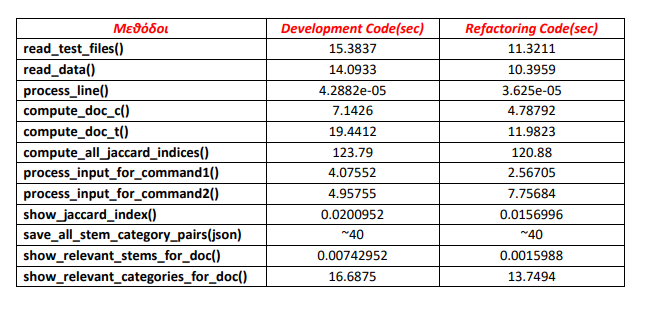

**Παρακάτω φαίνεται ένας πίνακας με τις διαφορές μνήμης που έχουν οι υλοποιήσεις σε κάθε μέθοδο που πειράξαμε!**

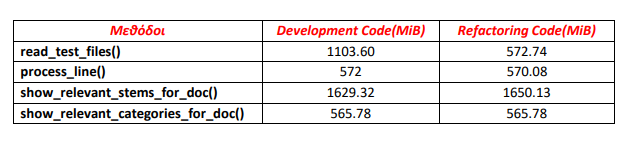

Οι βασικές αλλαγές που κάναμε στο time profiling έχουν και καλύτερη απόδοση μνήμης στο memory profiling!Στην 3η περίπτωση λόγω της μικρής διαφοράς μνήμης και της μεγάλης όμως σε χρόνο , προτιμάμε να χρησιμοποιήσουμε αυτήν την εκδοχή.

Συνεπώς κρατήσαμε τις παραπάνω αλλαγές και τις βάλαμε στον τελικό refactored κώδικα.

# Refactoring Phase

## ⏩ Κώδικας Refactoring Phase

Γράψτε στο παρακάτω code cell όλο τον κώδικα του Aggregative News Analyzer σας αλλαγμένο (refactored) με βάση τα bottlenecks που εντοπίσατε στο profiling και διορθώσατε στο refactoring, καθώς και με βάση τις αρχές της Idomatic Python.

In [ ]:
%%file aggregate_news_analyzer_refactored.py
import sys
import glob
import os
import operator
import json
from collections import defaultdict
from openpyxl import Workbook
from openpyxl.styles import Font


#path_to_files = "dataforproject1"
path_to_files = "/content/drive/MyDrive/filesforplh211"
term_to_stem_dict_instance = None

def process_input(user_input, jaccard_indices , list_of_data):
    '''
        Routine to process the user input,and execute the given command.
        @param0 the user input-command
        @param1 the jaccard indices computed in the beggining
        @param2 the list of data files.
    '''

    if user_input == '':
        print("Error: Missing input.")
        return None

    # split the user input into a list of arguments.
    args = user_input.split(" ") # space separated
    command = args[0]

    # 1.Show top <k> relevant stems for category
    if command == '@':

        process_input_for_command1(args, jaccard_indices)

    # 2.Show top <k> relevant categories for stem
    elif command == '#':

        process_input_for_command2(args, jaccard_indices )

    # 3.Show top <k> stem-category pairs with Jaccard Indexes
    elif command == '$':
        # Display the Jaccard Index for a stem-category pair
        if len(args) < 3:
            print("Error: Missing arguments for Jaccard Index.")
        else:
            show_jaccard_index(args[1], args[2], jaccard_indices)

    # 4.Save all stem-category pairs with Jaccard Indexes to a file
    elif command.startswith('*'):
       # Save all stem-category pairs with Jaccard Indexes to a file
        file = args[1].strip().split('.')
        filename = file[0]
        filetype = file[1]
        if filetype in ['json', 'xlsx']:
            save_all_stem_category_pairs(filename, filetype, jaccard_indices)
        else:
            print("Error: Unsupported file type. Please use 'json' or 'xlsx'.")

    # 5.Show all stem-category pairs with Jaccard Indexes
    elif command in ['P', 'C']:
        # Depending on the command, display either all stems or categories included in a document
        if len(args) < 3:
            print("Error: Missing arguments for document contents.")

        else:
            option = args[2]
            if option not in ('-t' , '-c'):
                print(f"Unknown option for {command} command!")
                return

            doc_id = args[1]
            if option == '-t':
                # Show all relevant term_ids with this doc_id
                show_relevant_stems_for_doc(command, doc_id , list_of_data)

            else: #option is '-c'
                #Show all relevant categories of this doc_id
                show_relevant_categories_for_doc( command , doc_id )
    else:
        print("Error: Unknown command.")

def process_input_for_command1(user_input, jaccard_indices):
    '''
        Routine to process user's input if the command is '@'
        @arg0 the user input
        @arg1 jaccard indices
    '''
    if len(user_input) < 3 :
        print("Error: Missing arguments for category relevance.")
    else:
        category = user_input[1]
        k = int(user_input[2])
        term_to_stem_map = get_term_to_stem_dict()

        # Get the relevant stem-category pairs with Jaccard Indexes
        dict_of_relevant_terms_with_indices = {}

        # Refactored to use dictionary comprehension for filtering
        dict_of_relevant_terms_with_indices = {
            key[1]:value
            for key,value in jaccard_indices.items() if key[0] == category
        }

        # Sort the stem-category pairs by Jaccard Index
        sorted_dict = dict(sorted( dict_of_relevant_terms_with_indices.items(), key=operator.itemgetter(1),reverse = True) )

        #get the k first terms in the dictionary
        term_list = list(sorted_dict.keys())[:k]

        print(f"Top {k} stems for category '{category}':")
        print("\n".join((term_to_stem_map[str(term_id)] for term_id in term_list)))



def process_input_for_command2(user_input, jaccard_indices ):
    '''
        Routine to process user's input if the command is '#'
        @arg0 the user input
        @arg1 jaccard indices
    '''

    # Display categories most relevant to a stem
    if len(user_input) < 3:
        print("Error: Missing arguments for stem relevance.")
    else:
        stem = user_input[1]
        k = int(user_input[2])

        term_to_stem_map = get_term_to_stem_dict()

        # Get the relevant stem-category pairs with Jaccard Indexes
        term = term_to_stem_map[stem]

        for key,value in term_to_stem_map.items():
            if term_to_stem_map[key] == stem:
                term = key
                break

        term_to_category = {
            key[0]:value
            for key, value in jaccard_indices.items()
            if key[1] == term
        }


        term_to_category = {}

        for key, value in jaccard_indices.items():
            if key[1] == term:
                term_to_category[key[0]] = value

        sorted_dict = dict(sorted( term_to_category.items(), key=operator.itemgetter(1) , reverse = True) )

        for index, category in enumerate(sorted_dict):
            if(index >= k):
                break
            print(category)


def show_jaccard_index(stem, category, jaccard_indices):
    '''
        Print the jaccard index for the stem and category given.
        @param0 stem
        @param1 category
        @param2 all the jaccard indices computed in previous steps.
    '''
    term_to_stem_map = get_term_to_stem_dict()

    try:
        # Get the relevant stem-category pairs with Jaccard Indexes
        term = [term_id for term_id in term_to_stem_map.keys() if term_to_stem_map[term_id] == stem][0]
        print(jaccard_indices[(category, term)])

    except IndexError:
        print(f"there is not such stem:{stem} inside!!!")


def read_map(file_path):
    '''
        Read the stem to term_id mapping from the file.
        @param0 the file path.
        Returns a dictionary with term to stem mapping {term_id : stem}
    '''
    term_id_to_stem = {}
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as map_file:
        # Skip the initial lines that don't contain term ID and stem mappings
        for _ in range(8):  # Adjust the number based on how many lines to skip
            next(map_file)
        # Read the rest of the file
        for line in map_file:
            try:
                stem , term_id , _ = line.strip().split()
                term_id_to_stem[term_id] = stem
            except ValueError:
                # Handle lines that don't conform to the expected format
                continue
    return term_id_to_stem

def get_term_to_stem_dict() :
    """
        Get the term-to-stem dictionary instance.
        This function is based on singleton design pattern.
    """
    # Use global keyword to change the global variable
    global term_to_stem_dict_instance

    if term_to_stem_dict_instance is None:
        map_file_path = path_to_files + "/stem.termid.idf.map.txt"
        term_to_stem_dict_instance = read_map(map_file_path)

    return term_to_stem_dict_instance


def compute_jaccard_index(doc_t, doc_c):
    """Compute the jaccard index.
        @param 0 , set of document IDs that have 'term id' inside
        @param 1 , set of document IDs that have 'category id' inside
    """
    intersection = doc_t.intersection(doc_c)
    intersection_cardinality = len(intersection)

    union_cardinality = len(doc_t) + len(doc_c) - intersection_cardinality

    return ( intersection_cardinality / union_cardinality )

def save_all_stem_category_pairs(filename, filetype, jaccard_indices):
    '''
    Save all Jaccard indices to a file (json/xlsx).
    @param filename: the filename of the file to read.
    @param filetype: the filetype (json/xslsx)
    @param jaccard_indices: all the Jaccard indices computed on previous steps.
    '''
    term_to_stem_map = get_term_to_stem_dict()

    if filetype == "json":
        with open(f"{filename}.json", "w") as json_file:
            data_to_write = {}
            for key, value in jaccard_indices.items():
                if key[1] in term_to_stem_map:
                    stem = term_to_stem_map[key[1]]
                    data_to_write[f"{stem} {key[0]}"] = value
            json_jaccard = json.dumps(data_to_write, ensure_ascii=False)
            json_file.write(json_jaccard)
    else:
        wb = Workbook()
        ws = wb.active

        headers = ["Stem", "Category", "Jaccard Index"]
        for col, header in enumerate(headers, start=1):
            cell = ws.cell(row=1, column=col)
            cell.value = header
            cell.font = Font(bold=True)

        i, col = 2, 1
        for key, value in jaccard_indices.items():
            if i == 1048576:
                i = 1
                col += 3
            if key[1] in term_to_stem_map:
                ws.cell(row=i, column=1 + col).value = term_to_stem_map[key[1]]
                ws.cell(row=i, column=2 + col).value = key[0]
                ws.cell(row=i, column=3 + col).value = value
                i += 1

        wb.save(f"{filename}.xlsx")

def show_relevant_stems_for_doc(command, doc_id, list_of_data):
    '''
    Show or Count all the relevant stems this doc_id contains.
    @param0 command: The command P/C for printing or counting respectively.
    @param1 doc_id: The doc id to find all its relevant terms.
    @param2 list_of_data: The list of data. Needed so we don't have to read again all the test files.
    '''
    relevant_terms = set()
    for data_dict in list_of_data:
        if doc_id in data_dict:
            relevant_terms.update(data_dict[doc_id])  # Add the set of term_ids

    # relevant_terms contains all relevant term_ids to this document

    id_to_stem_map = get_term_to_stem_dict()

    if command == 'P':
        relevant_stems = [id_to_stem_map[term_id] for term_id in relevant_terms]
        print('\n'.join(relevant_stems))
    else:  # command = 'C'
        print(f"Document:{doc_id} has {len(relevant_terms)} relevant terms.")

def show_relevant_categories_for_doc (command , doc):
    '''
        Show or Count all the relevant categories this doc_id contains.
        @param0 The command P/C for printing or counting respectively.
        @param1 The doc id to find all his relevant categories.
    '''
    relevant_categories_for_doc = defaultdict(set)
    with open( path_to_files + "/rcv1-v2.topics.qrels.txt", 'r') as file:
        for line in file:
            categ, doc_id, _  = line.strip().split()
            relevant_categories_for_doc[doc_id].add(categ) # add the relevant category to this document

    if command == 'P' :
        for cat in relevant_categories_for_doc[doc] :
            print(cat)
    else: # command = 'C'
        num_categories = len(relevant_categories_for_doc.get(doc, []))
        print(f"Document:{doc} has {num_categories} categories.")

def print_menu():
    """Prints all the available commands."""

    print("\nMenu:")
    print("@ <category> <k> - Show top <k> relevant stems for category <category>")
    print("# <stem> <k> - Show top <k> relevant categories for stem <stem>")
    print("$ <stem> <category> - Show the Jaccard Index for stem <stem> and category <category>")
    print("* <filename>.<filetype> - Save all stem-category pairs with Jaccard Indexes to a text file")
    print("P <did> -c|-t - Show all the categories of the doc_id or all the stems that doc_id contains respectively")
    print("C <did> -c|-t - Count all the categories of the doc_id or all the stems that doc_id contains respectively")
    print("To exit, type 'exit'")


def read_data(file_path):
    '''
        Read a test file in the given file path
        @param0 the file path
        Returns a dictionary {doc_id : {term_ids} }
    '''
    with open(file_path, 'r') as file:
        return {doc_id: term_ids for doc_id, term_ids in (process_line(line) for line in file)}

def process_line(line):
    '''
        Process the line of the test file.Keep only the indices we care about(doc_id -> term_ids)
        @param0 the line to process.
        Returns a dictionary with the mapping {doc_id : {term_ids} }
    '''
    parts = line.split()
    record_id = parts[0]
    # Use slicing to get every other part starting from index 1.
    term_ids = tuple((part.split(':')[0] for part in parts[1::2]))
    return record_id, term_ids


def read_test_files():
    """ Read test data files."""
    file_pattern = os.path.join(path_to_files, 'lyrl2004_vectors_test_pt1.dat.txt')
    #file_pattern = os.path.join(path_to_files, 'lyrl2004_vectors_test_pt*.dat.txt')


    list_of_data = [read_data(file_path) for file_path in glob.glob(file_pattern)]

    return list_of_data

def compute_doc_c():
    """ Compute DOC(C)
        How many doc_ids has each category.
        Returns a dictionary {category : {doc_ids}}
    """
    # Use defaultdict to automatically create a new set for new categories
    qrels = defaultdict(set)

    with open(path_to_files + "/rcv1-v2.topics.qrels.txt", 'r') as file:
        for line in file:
            categ, doc_id, _ = line.strip().split()
            # The set for the category is automatically created if it doesn't exist
            qrels[categ].add(doc_id)

    return qrels

def compute_doc_t(list_of_data):
    """ Compute doc_t
        How many doc_ids has each term_id.
        @param0 the test data(doc_id -> term_ids)
        Returns a dictionary {term_id : {doc_ids}}
    """
    # Using defaultdict to automatically create a new set for new term_ids
    doc_t = defaultdict(set)

    for data_dict in list_of_data:
        for doc_id, term_ids in data_dict.items():
            for term_id in term_ids:
                # The set for the term_id is automatically created if it doesn't exist
                doc_t[term_id].add(doc_id)

    return doc_t

def compute_all_jaccard_indices(doc_c, doc_t):
    # Compute all Jaccard indices
    jaccard_indices = {
        (category, term_id): compute_jaccard_index(doc_t[term_id], doc_c[category])
        for category in doc_c.keys()
        for term_id in doc_t.keys()
    }
    return jaccard_indices


def main():

    list_of_data = read_test_files() # list of dictionaries. : { doc_id : {term_ids} }

    # Read qrels file - compute DOC(C) , how many doc_ids has each category { category : {doc_ids} }
    doc_c = compute_doc_c()

    # Compute DOC(T) , how many doc_ids has each term_id : { term_id : {doc_ids} }
    doc_t = compute_doc_t(list_of_data)

    # compute all jaccard indices
    jaccard_indices = compute_all_jaccard_indices(doc_c , doc_t)

    # Delete doc_c and doc_t to save up memory as we have no further use for them
    del doc_c
    del doc_t

    while True:
        print_menu()
        user_input = input("Enter your command: ").strip() # Remove leading and trailing whitespace
        if user_input == 'exit':
            break
        process_input(user_input, jaccard_indices , list_of_data)


if __name__ == "__main__":
    sys.exit(main())

In [ ]:
import aggregate_news_analyzer_refactored

if __name__ == "__main__":
    aggregate_news_analyzer_refactored.main()

### ⏩⏩ **Time tests to compare the refactored/developed code:**

### For the development phase:

In [ ]:
def compute_all_jaccard_indices(doc_c , doc_t):
    # compute all jaccard indices
    jaccard_indices = {}
    for category in doc_c.keys():
        for term_id in doc_t.keys():
            jaccard_indices[ (category,term_id) ] = compute_jaccard_index( doc_t[term_id] , doc_c[category] )

    return jaccard_indices


In [ ]:
from aggregate_news_analyzer import compute_doc_c,read_data,compute_doc_t,compute_jaccard_index,process_input

In [ ]:
%%time

##Load files for procees input

# Compute DOC_C
doc_c = compute_doc_c()

# Compute DOC_T
test_file_path = "/content/drive/MyDrive/filesforplh211/lyrl2004_vectors_test_pt1.dat.txt"
test_data = []
test_data.append(read_data(test_file_path))
doc_t = compute_doc_t(test_data)

jac_indices = compute_all_jaccard_indices(doc_c , doc_t)

process_input("@ E11 40",jac_indices,test_data)

### For refactored version:

In [ ]:
from aggregate_news_analyzer_refactored import compute_doc_c,read_data,compute_doc_t,compute_jaccard_index,process_input,compute_all_jaccard_indices

In [ ]:
%%time

##Load files for procees input

# Compute DOC_C
doc_c = compute_doc_c()

# Compute DOC_T
test_file_path = "/content/drive/MyDrive/filesforplh211/lyrl2004_vectors_test_pt1.dat.txt"
test_data = []
test_data.append(read_data(test_file_path))
doc_t = compute_doc_t(test_data)

jac_indices = compute_all_jaccard_indices(doc_c , doc_t)

process_input("@ E11 40",jac_indices,test_data)

-----


## ⏩⏩ **Memory tests to compare the refactored/developed code:**

### For the development phase:

In [ ]:
from aggregate_news_analyzer import compute_doc_c,read_data,compute_doc_t,compute_jaccard_index,process_input

In [ ]:
%%memit

##Load files for procees input

# Compute DOC_C
doc_c = compute_doc_c()

# Compute DOC_T
test_file_path = "/content/drive/MyDrive/filesforplh211/lyrl2004_vectors_test_pt1.dat.txt"
test_data = []
test_data.append(read_data(test_file_path))
doc_t = compute_doc_t(test_data)

jac_indices = compute_all_jaccard_indices(doc_c , doc_t)

process_input("@ E11 40",jac_indices,test_data)

## For the refactored version:

In [ ]:
from aggregate_news_analyzer_refactored import compute_doc_c,read_data,compute_doc_t,compute_jaccard_index,process_input,compute_all_jaccard_indices

In [ ]:
%%memit

##Load files for procees input

# Compute DOC_C
doc_c = compute_doc_c()

# Compute DOC_T
test_file_path = "/content/drive/MyDrive/filesforplh211/lyrl2004_vectors_test_pt1.dat.txt"
test_data = []
test_data.append(read_data(test_file_path))
doc_t = compute_doc_t(test_data)

jac_indices = compute_all_jaccard_indices(doc_c , doc_t)
# simulating what we did in main to save up memory
del doc_c
del doc_t
process_input("@ E11 40",jac_indices,test_data)

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Refactoring Phase

Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Refactoring Phase και πως άλλαξε ώστε να γίνει πιο γρήγορος ή ώστε να καταναλώνει λιγότερη μνήμη ή να βρίσκει καλύτερο trade-off ανάμεσα σε αυτά τα δύο, με βάση τα συμπεράσματα της Profling Phase.

Ο κώδικας που προέκυψε στο refactoring phase επιτελεί τις ίδιες λειτουργίες με αυτόν στο development phase αλλά έχει τροποποιηθεί κατάλληλα ώστε να έχουμε όσο το δυνατόν καλύτερη απόδοση σε χρόνο και μνήμη. Θεωρήσαμε σημαντικό για την καλύτερη εξυπηρέτηση του χρήστη να γίνονται γρήγορα όλα τα queries και να υποστεί μια καθυστέρηση στην αρχή, λόγω της φόρτωσης όλων των απαιτούμενων αρχείων και τον υπολογισμό των jaccard index, αντί να υπάρχει καθυστέρηση κατά την στιγμή που θα παραχθεί το response.

Με βάση τα αποτελέσματα των δοκιμών που έγιναν κατά το profiling phase
αποφασίσαμε να γίνουν οι εξής αλλάγες στον κώδικα, συγκριτικά με το development phase:

* `read_test_files()` : χρήση list comprehension ή χρήση generator και μετέπειτα
cast σε tuple.

* `read_data()` : χρήση dict comprehension με εσωτερικό υπολογισμό των processed line σε generator object.

* `process_line()`: χρήση generator και μετέπειτα cast σε tuple του line αντί χρήση set comprehension.

* `compute_doc_c()` : χρήση του defaultdict(set) γλυτώνοντας έναν έλεγχο για την ύπαρξη του set μέσα στο loop.

* `compute_doc_t()` : χρήση του defaultdict(set) γλυτώνοντας έναν έλεγχο για την ύπαρξη του set μέσα στο loop.

* `compute_all_jaccard_indices()` : χρήση dict comprehension αντί χρήση διπλού loop.

* `process_input_for_command1()` : χρήση dict comprehension και χρήση της join για string concatenation και έπειτα ένα print αντί διαδοχικά πολλαπλά prints.

* `process_input_for_command2()` : δεν θα χρησιμοποιηθεί η αλλαγή που προτείναμε καθώς αυτό κάνει πιο αργό τον κώδικα για μερικά δευτερόλεπτα.

* `save_all_stem_category_pairs()` : χρήση των fstrings αντί απλού string concatenation.

* `show_relevant_stems_for_doc()` : χρήση της update() αντί της union() για την ενημέρωση του set.

* `show_relevant_categories_for_doc()` : χρήση του defaultdict(set) και επίσης χρήση της dictionary.get() για αποφυγή KeyError σε περίπτωση που προσπαθήσουμε να κάνουμε άμεση πρόσβαση στο value μέσω του κλειδιού.

* `main()`: Τοποθέτησαμε τις εντολές `del doc_c` και `del doc_t` μετά τον υπολογισμό των jaccard index για την εξοικονόμιση χώρου, καθώς δεν είχε κάποια παραπάνω χρησιμότητα η ύπαρξη τους.

Έτσι επιτυγχάνουμε την εξοικονόμιση τόσο σε χρόνο όσο και σε κάποια MB χώρου βελτιστοποιώντας τον κώδικα του development phase.


# Unit Testing Phase

## ⏩ Κώδικας Unit Testing Phase

Γράψτε στο παρακάτω code cell όλο τον κώδικα που κάνει unit testing σε κάθε unit του refactored κώδικα της προηγούμενης φάσης.

*Υπόδειξη: στην απλή περίπτωση τα δικά σας units είναι μέθοδοι που υλοποιούν τις εντολές που μπορεί να δεχτεί ο Aggregative News Analyzer από το χρήστη ΚΑΙ μεθόδους υπολογισμού Jaccard Index όπου και όπως απαιτείται.*

**Για την επιτυχή ολοκλήρωση των unit tests έπρεπε να γίνουν κάποιες μικρές προσαρμογές στον κώδικα που κάναμε στο refactoring χωρίς να αλλάζει η λογική και η λειτουργικότητα του , απλώς προστέθηκαν κατάλληλα return αντί print σε σημεία όπου απαιτείται για να μπορέσει να γίνει ορθός έλεγχος αργότερα.**

In [5]:
%%file aggregate_news_analyzer_refactored.py
import sys
import glob
import os
import operator
import json
from collections import defaultdict
from openpyxl import Workbook
from openpyxl.styles import Font


#path_to_files = "dataforproject1"
path_to_files = "/content/drive/MyDrive/filesforplh211"
term_to_stem_dict_instance = None

def process_input(user_input, jaccard_indices , list_of_data):
    '''
        Routine to process the user input,and execute the given command.
        @param0 the user input-command
        @param1 the jaccard indices computed in the beggining
        @param2 the list of data files.
    '''

    if user_input == '':
        print("Error: Missing input.")
        return None

    # split the user input into a list of arguments.
    args = user_input.split(" ") # space separated
    command = args[0]

    # 1.Show top <k> relevant stems for category
    if command == '@':

        ret_val = process_input_for_command1(args, jaccard_indices)
        return ret_val

    # 2.Show top <k> relevant categories for stem
    elif command == '#':

        ret_val = process_input_for_command2(args, jaccard_indices )
        return ret_val

    # 3.Show top <k> stem-category pairs with Jaccard Indexes
    elif command == '$':
        # Display the Jaccard Index for a stem-category pair
        if len(args) < 3:
            print("Error: Missing arguments for Jaccard Index.")
        else:
            show_jaccard_index(args[1], args[2], jaccard_indices)

    # 4.Save all stem-category pairs with Jaccard Indexes to a file
    elif command.startswith('*'):
       # Save all stem-category pairs with Jaccard Indexes to a file
        file = args[1].strip().split('.')
        filename = file[0]
        filetype = file[1]
        if filetype in ['json', 'xlsx']:
            save_all_stem_category_pairs(filename, filetype, jaccard_indices)
        else:
            print("Error: Unsupported file type. Please use 'json' or 'xlsx'.")

    # 5.Show all stem-category pairs with Jaccard Indexes
    elif command in ['P', 'C']:
        # Depending on the command, display either all stems or categories included in a document
        if len(args) < 3:
            print("Error: Missing arguments for document contents.")

        else:
            option = args[2]
            if option not in ('-t' , '-c'):
                print(f"Unknown option for {command} command!")
                return

            doc_id = args[1]
            if option == '-t':
                # Show all relevant term_ids with this doc_id
                show_relevant_stems_for_doc(command, doc_id , list_of_data)

            else: #option is '-c'
                #Show all relevant categories of this doc_id
                show_relevant_categories_for_doc( command , doc_id )
    else:
        print("Error: Unknown command.")

def process_input_for_command1(user_input, jaccard_indices):
    '''
        Routine to process user's input if the command is '@'
        @arg0 the user input
        @arg1 jaccard indices
    '''
    if len(user_input) < 3 :
        print("Error: Missing arguments for category relevance.")
    else:
        category = user_input[1]
        k = int(user_input[2])
        term_to_stem_map = get_term_to_stem_dict()

        # Get the relevant stem-category pairs with Jaccard Indexes
        dict_of_relevant_terms_with_indices = {}

        # Refactored to use dictionary comprehension for filtering
        dict_of_relevant_terms_with_indices = {
            key[1]:value
            for key,value in jaccard_indices.items() if key[0] == category
        }

        # Sort the stem-category pairs by Jaccard Index
        sorted_dict = dict(sorted( dict_of_relevant_terms_with_indices.items(), key=operator.itemgetter(1),reverse = True) )

        #get the k first terms in the dictionary
        term_list = list(sorted_dict.keys())[:k]

        ret_val = []

        #print(f"Top {k} stems for category '{category}':")
        for term_id in term_list:
            ret_val.append(term_to_stem_map[str(term_id)])
            print(term_to_stem_map[str(term_id)])

        return ret_val



def process_input_for_command2(user_input, jaccard_indices ):
    '''
        Routine to process user's input if the command is '#'
        @arg0 the user input
        @arg1 jaccard indices
    '''

    # Display categories most relevant to a stem
    if len(user_input) < 3:
        print("Error: Missing arguments for stem relevance.")
    else:
        stem = user_input[1]
        k = int(user_input[2])

        term_to_stem_map = get_term_to_stem_dict()

        # Get the relevant stem-category pairs with Jaccard Indexes
        term = 0


        for key,value in term_to_stem_map.items():
            if term_to_stem_map[key] == stem:
                term = key
                break

        term_to_category = {
            key[0]:value
            for key, value in jaccard_indices.items()
            if key[1] == term
        }


        term_to_category = {}

        for key, value in jaccard_indices.items():
            if key[1] == term:
                term_to_category[key[0]] = value

        sorted_dict = dict(sorted( term_to_category.items(), key=operator.itemgetter(1) , reverse = True) )

        ret_val = []
        for index, category in enumerate(sorted_dict):
            if(index >= k):
                break
            ret_val.append(category)
            print(category)


        return ret_val


def show_jaccard_index(stem, category, jaccard_indices):
    '''
        Print the jaccard index for the stem and category given.
        @param0 stem
        @param1 category
        @param2 all the jaccard indices computed in previous steps.
    '''
    term_to_stem_map = get_term_to_stem_dict()

    try:
        # Get the relevant stem-category pairs with Jaccard Indexes
        term = [term_id for term_id in term_to_stem_map.keys() if term_to_stem_map[term_id] == stem][0]
        #print(jaccard_indices[(category, term)])
        return jaccard_indices[(category, term)]

    except IndexError:
        print(f"there is not such stem:{stem} inside!!!")


def read_map(file_path):
    '''
        Read the stem to term_id mapping from the file.
        @param0 the file path.
        Returns a dictionary with term to stem mapping {term_id : stem}
    '''
    term_id_to_stem = {}
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as map_file:
        # Skip the initial lines that don't contain term ID and stem mappings
        for _ in range(8):  # Adjust the number based on how many lines to skip
            next(map_file)
        # Read the rest of the file
        for line in map_file:
            try:
                stem , term_id , _ = line.strip().split()
                term_id_to_stem[term_id] = stem
            except ValueError:
                # Handle lines that don't conform to the expected format
                continue
    return term_id_to_stem

def get_term_to_stem_dict() :
    """
        Get the term-to-stem dictionary instance.
        This function is based on singleton design pattern.
    """
    # Use global keyword to change the global variable
    global term_to_stem_dict_instance

    if term_to_stem_dict_instance is None:
        map_file_path = path_to_files + "/stem.termid.idf.map.txt"
        term_to_stem_dict_instance = read_map(map_file_path)

    return term_to_stem_dict_instance


def compute_jaccard_index(doc_t, doc_c):
    """Compute the jaccard index.
        @param 0 , set of document IDs that have 'term id' inside
        @param 1 , set of document IDs that have 'category id' inside
    """
    intersection = doc_t.intersection(doc_c)
    intersection_cardinality = len(intersection)

    union_cardinality = len(doc_t) + len(doc_c) - intersection_cardinality

    return ( intersection_cardinality / union_cardinality )

def save_all_stem_category_pairs(filename, filetype, jaccard_indices):
    '''
    Save all Jaccard indices to a file (json/xlsx).
    @param filename: the filename of the file to read.
    @param filetype: the filetype (json/xslsx)
    @param jaccard_indices: all the Jaccard indices computed on previous steps.
    '''
    term_to_stem_map = get_term_to_stem_dict()

    if filetype == "json":
        with open(f"{filename}.json", "w") as json_file:
            data_to_write = {}
            for key, value in jaccard_indices.items():
                if key[1] in term_to_stem_map:
                    stem = term_to_stem_map[key[1]]
                    data_to_write[f"{stem} {key[0]}"] = value
            json_jaccard = json.dumps(data_to_write, ensure_ascii=False)
            json_file.write(json_jaccard)
    else:
        wb = Workbook()
        ws = wb.active

        headers = ["Stem", "Category", "Jaccard Index"]
        for col, header in enumerate(headers, start=1):
            cell = ws.cell(row=1, column=col)
            cell.value = header
            cell.font = Font(bold=True)

        i, col = 2, 1
        for key, value in jaccard_indices.items():
            if i == 1048576:
                i = 1
                col += 3
            if key[1] in term_to_stem_map:
                ws.cell(row=i, column=1 + col).value = term_to_stem_map[key[1]]
                ws.cell(row=i, column=2 + col).value = key[0]
                ws.cell(row=i, column=3 + col).value = value
                i += 1

        wb.save(f"{filename}.xlsx")

def show_relevant_stems_for_doc(command, doc_id, list_of_data):
    '''
    Show or Count all the relevant stems this doc_id contains.
    @param0 command: The command P/C for printing or counting respectively.
    @param1 doc_id: The doc id to find all its relevant terms.
    @param2 list_of_data: The list of data. Needed so we don't have to read again all the test files.
    '''
    relevant_terms = set()
    for data_dict in list_of_data:
        if doc_id in data_dict:
            relevant_terms.update(data_dict[doc_id])  # Add the set of term_ids

    # relevant_terms contains all relevant term_ids to this document

    id_to_stem_map = get_term_to_stem_dict()

    ret_val = []

    if command == 'P':
        for term_id in relevant_terms:
            ret_val.append(id_to_stem_map[term_id] )

            #print( id_to_stem_map[term_id] )

        return ret_val

    else: #command = 'C'
        #print(f"Document:{doc_id} has {len(relevant_terms)} relevant terms. ")
        return len(relevant_terms)


def show_relevant_categories_for_doc (command , doc):
    '''
        Show or Count all the relevant categories this doc_id contains.
        @param0 The command P/C for printing or counting respectively.
        @param1 The doc id to find all his relevant categories.
    '''
    relevant_categories_for_doc = defaultdict(set)
    with open( path_to_files + "/rcv1-v2.topics.qrels.txt", 'r') as file:
        for line in file:
            categ, doc_id, _  = line.strip().split()
            relevant_categories_for_doc[doc_id].add(categ) # add the relevant category to this document

    ret_val = []

    if command == 'P' :
        for cat in relevant_categories_for_doc[doc] :
            ret_val.append(cat)
            print(cat)
        return ret_val
    else: # command = 'C'
        print(f"Document:{doc} has {len(relevant_categories_for_doc[doc])} categories. ")
        return len(relevant_categories_for_doc[doc])

def print_menu():
    """Prints all the available commands."""

    print("\nMenu:")
    print("@ <category> <k> - Show top <k> relevant stems for category <category>")
    print("# <stem> <k> - Show top <k> relevant categories for stem <stem>")
    print("$ <stem> <category> - Show the Jaccard Index for stem <stem> and category <category>")
    print("* <filename>.<filetype> - Save all stem-category pairs with Jaccard Indexes to a text file")
    print("P <did> -c|-t - Show all the categories of the doc_id or all the stems that doc_id contains respectively")
    print("C <did> -c|-t - Count all the categories of the doc_id or all the stems that doc_id contains respectively")
    print("To exit, type 'exit'")


def read_data(file_path):
    '''
        Read a test file in the given file path
        @param0 the file path
        Returns a dictionary {doc_id : {term_ids} }
    '''
    with open(file_path, 'r') as file:
        return {doc_id: term_ids for doc_id, term_ids in (process_line(line) for line in file)}

def process_line(line):
    '''
        Process the line of the test file.Keep only the indices we care about(doc_id -> term_ids)
        @param0 the line to process.
        Returns a dictionary with the mapping {doc_id : {term_ids} }
    '''
    parts = line.split()
    record_id = parts[0]
    # Use slicing to get every other part starting from index 1.
    term_ids = tuple((part.split(':')[0] for part in parts[1::2]))
    return record_id, term_ids


def read_test_files():
    """ Read test data files."""
    file_pattern = os.path.join(path_to_files, 'lyrl2004_vectors_test_pt1.dat.txt')
    #file_pattern = os.path.join(path_to_files, 'lyrl2004_vectors_test_pt*.dat.txt')


    list_of_data = [read_data(file_path) for file_path in glob.glob(file_pattern)]

    return list_of_data

def compute_doc_c():
    """ Compute DOC(C)
        How many doc_ids has each category.
        Returns a dictionary {category : {doc_ids}}
    """
    # Use defaultdict to automatically create a new set for new categories
    qrels = defaultdict(set)

    with open(path_to_files + "/rcv1-v2.topics.qrels.txt", 'r') as file:
        for line in file:
            categ, doc_id, _ = line.strip().split()
            # The set for the category is automatically created if it doesn't exist
            qrels[categ].add(doc_id)

    return qrels

def compute_doc_t(list_of_data):
    """ Compute doc_t
        How many doc_ids has each term_id.
        @param0 the test data(doc_id -> term_ids)
        Returns a dictionary {term_id : {doc_ids}}
    """
    # Using defaultdict to automatically create a new set for new term_ids
    doc_t = defaultdict(set)

    for data_dict in list_of_data:
        for doc_id, term_ids in data_dict.items():
            for term_id in term_ids:
                # The set for the term_id is automatically created if it doesn't exist
                doc_t[term_id].add(doc_id)

    return doc_t

def compute_all_jaccard_indices(doc_c, doc_t):
    # Compute all Jaccard indices
    jaccard_indices = {
        (category, term_id): compute_jaccard_index(doc_t[term_id], doc_c[category])
        for category in doc_c.keys()
        for term_id in doc_t.keys()
    }
    return jaccard_indices


def main():

    list_of_data = read_test_files() # list of dictionaries. : { doc_id : {term_ids} }

    # Read qrels file - compute DOC(C) , how many doc_ids has each category { category : {doc_ids} }
    doc_c = compute_doc_c()

    # Compute DOC(T) , how many doc_ids has each term_id : { term_id : {doc_ids} }
    doc_t = compute_doc_t(list_of_data)

    # compute all jaccard indices
    jaccard_indices = compute_all_jaccard_indices(doc_c , doc_t)

    del doc_c
    del doc_t

    while True:
        print_menu()
        user_input = input("Enter your command: ").strip() # Remove leading and trailing whitespace
        if user_input == 'exit':
            break
        process_input(user_input, jaccard_indices , list_of_data)


if __name__ == "__main__":
    sys.exit(main())

Writing aggregate_news_analyzer_refactored.py


In [6]:
%%file test_aggregate_news_analyzer_refactored.py
import sys
import unittest
import glob
import os
import operator
import json
from openpyxl import Workbook
from openpyxl.styles import Font
import aggregate_news_analyzer_refactored


path_to_files = "/content/drive/MyDrive/filesforplh211"
test_data = None
term_to_stem = None
map_file_path = None
doc_c = None
doc_t = None
jaccard_indices = None

class TestAggregateNewsAnalyzer(unittest.TestCase):

    #setUpClass to create everything we will need later , use global variables so we can access them in
    #other tests as well so we don't have to create them all over again , we keep our code D.R.Y
    @classmethod
    def setUpClass(cls):
        global test_data
        global jaccard_indices
        global path_to_files
        global map_file_path
        global term_to_stem
        global doc_c
        global doc_t

        test_data = aggregate_news_analyzer_refactored.read_test_files()

        map_file_path = path_to_files + "/stem.termid.idf.map.txt"
        term_to_stem = aggregate_news_analyzer_refactored.get_term_to_stem_dict()

        doc_c = aggregate_news_analyzer_refactored.compute_doc_c()

        doc_t = aggregate_news_analyzer_refactored.compute_doc_t(test_data)


        jaccard_indices = {}
        for category in doc_c.keys():
            for term_id in doc_t.keys():
                jaccard_indices[ (category,term_id) ] = aggregate_news_analyzer_refactored.compute_jaccard_index( doc_t[term_id] , doc_c[category] )




    def test_compute_doc_c(self):
        global doc_c

        # let's see if the function actually works and returns something
        self.assertIsNotNone(doc_c)

        #Now we know is not None , test it has a value we know inside
        self.assertIn( "737264" , doc_c["E11"])

        # 1 is not inside for sure
        self.assertNotIn( "1" , doc_c["E11"])



    def test_compute_doc_t(self):
        global doc_t

        #doc_t should not be None
        self.assertIsNotNone(doc_t)

        #test for known pair doc_t["6622"] = (... , "282341" , ...)
        self.assertIn("282341" , doc_t["6622"])

        #test a random pair is not in
        self.assertNotIn("11111" , doc_t["6622"])



    def test_compute_jaccard_index(self):

        global jaccard_indices


        self.assertIsNotNone(jaccard_indices)

        #cell 7078
        #GSCI
        #C23
        #GHEA
        #C22
        #GCRIM

        #tets calculations are correct based on a known outcome
        self.assertEqual(0.02243829468960359 , jaccard_indices[("GSCI","7078")] )


        #jaccard indexes must be in a decending order
        self.assertGreater(jaccard_indices[("GSCI","7078")] , jaccard_indices[("C23","7078")])

        self.assertGreater(jaccard_indices[("C23","7078")] , jaccard_indices[("GHEA","7078")])



    def test_process_line(self):

      #get a line with head command
      line = "226739  274:0.202582682548721 5045:0.0670981612122457 5051:0.284355329887589 6622:0.205147176924681 6626:0.117848795429683 6691:0.0942965479130347 7119:0.0384312477652938 7633:0.148672271771316 8562:0.0684213395724658 9855:0.166060061423281 10232:0.168726673812133 11516:0.25266184708198 14057:0.139169976915967 14143:0.0604774228574716 19447:0.0454500884764796 23300:0.308053643082997 24892:0.0551892023476974 27017:0.101967412765911 28211:0.217553185260237 28747:0.070062069687768 29685:0.106450883630066 29793:0.0359232076929684 30549:0.178466069758836 31219:0.171373384168174 31576:0.0861953419740975 32919:0.168085083049846 33330:0.150073091721802 33718:0.244234292426081 34910:0.0362918855942215 35410:0.111538633156898 35414:0.217553185260237 35879:0.205147176924681 36638:0.0738711758057536 36765:0.133131990795911 42841:0.0371713337185607 42936:0.0736323289151816 43003:0.231328997155902 43950:0.127168016772662 44546:0.112590147623065 44652:0.211515769382519 46097:0.111745325386202 46099:0.100356688435027 46545:0.0202101693727439"
      record_id, term_ids = aggregate_news_analyzer_refactored.process_line(line)

      self.assertEqual(record_id , "226739")

      self.assertIsNotNone(term_ids)
      self.assertIn("6626" , term_ids)



    def test_get_term_to_stem_dict(self):

      global term_to_stem

      rec1  = aggregate_news_analyzer_refactored.get_term_to_stem_dict()

      self.assertIsNotNone(term_to_stem)
      self.assertIsNotNone(rec1)

      #test singleton design pattern
      self.assertIs(rec1 , term_to_stem)

      #alicur 1223
      self.assertTrue("alicur", term_to_stem["1223"])



    def test_read_test_files(self):

        global test_data
        global path_to_files  # Declare the use of the global variable


        data = test_data
        self.assertIsNotNone(data)

        #226748 30476:0.124686590026138 31184:0.0556026265357491 32231:0.153078810604172 32468:0.048694505427813 33310:0.0793445639675806 34010:0.21482123256684
        self.assertIn("226748" , data[0].keys())

        #assert something we know it is inside , actually is
        self.assertIn("32468" , data[0]["226748"])

        #2 must not be inside the dictionary
        self.assertNotIn("2" , data[0]["226748"])



    def test_read_map(self):

      global term_to_stem

      self.assertIsNotNone(term_to_stem)

      #einstein 12435
      self.assertEqual("einstein" , term_to_stem["12435"])


      self.assertNotEqual("plh211" , term_to_stem["11111"])


    def test_show_relevant_stems_for_doc(self):

      global test_data


      #**********************Test "for P <did> -t" option**********************


      #7
      #a0


      #226748
      #expert
      #Document:226748 has 7 categories.
      #Document:226748 has 45 relevant terms.

      #this doc id does not have terms assosiated with it
      list_of_stems = aggregate_news_analyzer_refactored.show_relevant_stems_for_doc("P" , "7" , test_data)

      #this should be empty but not None
      self.assertIsNotNone(list_of_stems)
      self.assertTrue(len(list_of_stems) == 0)



      list_of_stems = aggregate_news_analyzer_refactored.show_relevant_stems_for_doc("P" , "226748" , test_data)

      #this list should not be empty
      self.assertIsNotNone(list_of_stems)

      #list with this doc id should have at least 1 element inside
      self.assertTrue(len(list_of_stems) > 0)

      self.assertIn("expert" , list_of_stems)



      #**********************Test "for C <did> -t" option**********************

      num_of_stems = aggregate_news_analyzer_refactored.show_relevant_stems_for_doc("C" , "7" , test_data)

      #this should be empty but not None
      self.assertIsNotNone(num_of_stems)

      self.assertTrue(num_of_stems == 0)



      num_of_stems = aggregate_news_analyzer_refactored.show_relevant_stems_for_doc("C" , "226748" , test_data)

      #something must be returned
      self.assertIsNotNone(num_of_stems)

      # with this doc id we should have at least 1 element
      self.assertGreater(num_of_stems , 0)



    def test_show_relevant_categories_for_doc(self):

      #**********************Test "for P <did> -c" option**********************


      #7
      #a0


      #226748
      #CCAT
      #expert
      #Document:226748 has 7 categories.
      #Document:226748 has 45 relevant terms.



      list_of_cat = aggregate_news_analyzer_refactored.show_relevant_categories_for_doc("P" , "226748" )

      #this list should not be empty
      self.assertIsNotNone(list_of_cat)

      #list with this doc id should have at least 1 element inside
      self.assertTrue(len(list_of_cat) > 0)

      self.assertIn("CCAT" , list_of_cat)



      #**********************Test "for C <did> -c" option**********************

      #num_of_cat = aggregate_news_analyzer.show_relevant_categories_for_doc("C" , "7" )

      #this should be empty but not None
      #self.assertIsNotNone(num_of_cat)

      #self.assertTrue(num_of_cat == 0)



      num_of_cat = aggregate_news_analyzer_refactored.show_relevant_categories_for_doc("C" , "226748")

      #something must be returned
      self.assertIsNotNone(num_of_cat)

      # with this doc id we should have at least 1 element
      self.assertGreater(num_of_cat , 0)



    #put by hand values and test the output and possible exceptions
    def test_process_input(self):

      global jaccard_indices
      global test_data

      #**********************Test process_input_papaki case**********************

      #CCAT
      #298956

      #get the top 5 based on jaccard indices stems for category "CCAT"
      list_of_stems = aggregate_news_analyzer_refactored.process_input("@ GJOB 5", jaccard_indices , test_data)

      # this should not be None eitherway
      self.assertIsNotNone(list_of_stems)

      #we know this category has at least 1 assosiated stem
      self.assertTrue(len(list_of_stems) > 0)



      #test that the 5 stems we got are in correct order based on jaccard indexes
      for i in range(4):
        self.assertGreater(aggregate_news_analyzer_refactored.show_jaccard_index(list_of_stems[i], "GJOB" , jaccard_indices) , \
                           aggregate_news_analyzer_refactored.show_jaccard_index(list_of_stems[i+1], "GJOB" , jaccard_indices))



      #On perpose put false parameter (stem instead of category)
      list_of_stems = aggregate_news_analyzer_refactored.process_input("@ einstein 5", jaccard_indices , test_data)

      # this should not be None eitherway
      self.assertIsNotNone(list_of_stems)

      #false command so the list must be empty
      self.assertTrue(len(list_of_stems) == 0)

      #**********************Test process_input_hashtag case**********************


      #GODD
      list_of_categories = aggregate_news_analyzer_refactored.process_input("# yasuo 5", jaccard_indices , test_data)

      # this should not be None eitherway
      self.assertIsNotNone(list_of_categories)

      #we know this stem has at least 1 assosiated category
      self.assertTrue(len(list_of_categories) > 0)

      for i in range(4):
        self.assertGreater(aggregate_news_analyzer_refactored.show_jaccard_index("yasuo", list_of_categories[i], jaccard_indices) , \
                           aggregate_news_analyzer_refactored.show_jaccard_index("yasuo", list_of_categories[i+1] , jaccard_indices))



      #On perpose put false parameter (category instead of stem)
      list_of_categories = aggregate_news_analyzer_refactored.process_input("# GJOB 5", jaccard_indices , test_data)

      # this should not be None eitherway
      self.assertIsNotNone(list_of_categories)

      #This command should return the list empty
      self.assertTrue(len(list_of_categories) == 0)


    def test_save_all_stem_category_pairs(self):
        global test_data
        global jaccard_indices
        global term_to_stem_map

        aggregate_news_analyzer_refactored.save_all_stem_category_pairs("saved_data" , "json" , jaccard_indices)

        #os.path.exists returns true if the file exists else false
        check_exist = os.path.exists("saved_data.json")

        #this file must exist
        self.assertTrue(check_exist)


        file_size = os.path.getsize("saved_data.json")

        #now that the file exists , check it has content inside
        self.assertTrue(file_size != 0)

        file_path = 'saved_data.json'

        with open(file_path, 'r') as file:
            data = json.load(file)

        # Get the first key and its value
        first_key = next(iter(data))
        first_value = data[first_key]

        # Split the first key into stem and category
        keys_parts = first_key.split(" ")
        stem = keys_parts[0]
        category = keys_parts[1]

        # Assuming term_to_stem is defined somewhere in your code
        for key, value in term_to_stem.items():
            if value == stem:
                term = key
                break

        # Assuming jaccard_indices is a dictionary or similar structure
        index_value = jaccard_indices[category, term]

        # Check if the values match
        self.assertTrue(index_value == first_value)



if __name__ == "__main__":
    sys.exit(unittest.main())

Writing test_aggregate_news_analyzer_refactored.py


Γράψτε στο παρακάτω code cell όλο τον κώδικα του Aggregative News Analyzer σας με τις αλλαγές που ενδεχομένως προέκυψαν μετά το unit testing (αν υπήρχαν τέτοιες αλλαγές).

In [7]:
! python test_aggregate_news_analyzer_refactored.py

....work
union
labor
employ
strik
M142
C12
E11
E12
M132
.....GPOL
C42
GJOB
GCAT
E41
ECAT
CCAT
Document:226748 has 7 categories. 
..
----------------------------------------------------------------------
Ran 11 tests in 126.188s

OK


### **Για λεπτομερέστερη επισκόπηση της ολότητας των test του κώδικα μας εκτελέστε τα παρακάτω:**

In [8]:
!pip install coverage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 4.0 MB/s eta 0:00:00


In [9]:
!coverage run -m unittest test_aggregate_news_analyzer_refactored.py

....work
union
labor
employ
strik
M142
C12
E11
E12
M132
.....C42
GCAT
ECAT
GPOL
CCAT
GJOB
E41
Document:226748 has 7 categories. 
..
----------------------------------------------------------------------
Ran 11 tests in 204.491s

OK


In [10]:
!coverage report

Name                                         Stmts   Miss  Cover
----------------------------------------------------------------
aggregate_news_analyzer_refactored.py          221     70    68%
test_aggregate_news_analyzer_refactored.py     124      1    99%
----------------------------------------------------------------
TOTAL                                          345     71    79%


## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Unit Testing Phase

**Σε αυτό το τελευταίο βήμα θα τεστάρουμε τον κώδικα που υλοποιήσαμε στο προηγούμενο στάδιο του refactoring με τη χρήση του module unittest και της έτοιμης σουιτας απο συναρτήσεις τύπου assert της python.Έτσι , για να έχουμε μία ολοκληρωμένη ασφάλεια και απόλυτη σιγουριά για τα αποτελέσματα και την ευρωστότητα του κώδικα μας θα δημιουργήσουμε test για κάθε συνάρτηση και υποσυνάρτηση που καλείται, δηλαδή θα κάνουμε bottom-up testing.Για να μπορέσουμε να επιτύχουμε τα παραπάνω δημιουργήσαμε τα εξής test τα οποία παρουσιάζονται παρακάτω και θα αναλυθούν περαιτέρω στη συνέχεια.**


* `test_compute_doc_c`
* `test_compute_doc_t`
* `test_compute_jaccard_index`
* `test_process_line`
* `test_get_term_to_stem_dict`
* `test_read_test_files`
* `test_read_map`
* `test_show_relevant_stems_for_doc`
* `test_show_relevant_categories_for_doc`
* `test_process_input`
* `test_save_all_stem_category_pairs`

#### Στην αρχή για να μπορέσουμε να έχουμε τα test data , jaccard_indexes και γενικότερα όσα δεδομένα μας χρειάζονται γενικότερα στη διεξαγωγή τών test τοποθετήθηκαν στην αρχή στην συνάρτηση setUpClass έτσι ώστε πρίν την αρχή των test να δημιουργούνται και να κρατούνται σε global μεταβλητές για την διευκόλυνση μας έτσι ώστε να μην χρειάζεται πριν απο κάθε test να υπολογίζουμε το καθένα καθώς κάτι τέτοιο θα ήταν απόστευτα κοστοβόρο σε χρόνο.

#### Ανάλυση κάθε test συνάρτησης:

#### ▶`test_compute_doc_c`:
**Σε αυτή τη συνάρτηση εφόσον έχουμε υπολογίσει τα δεδομένα αρχικά με τη χρήση της `assertIsNotNone` θα βεβαιωθούμε ότι δεν δουλεύουμε πάνω σε κενό σύνολο , στη συνέχεια θέλουμε να ελέγξουμε την ορθότητα του συνόλου , θα πάρουμε ένα τυχαίο ζεύγος απο το αρχείο `rcv1-v2.topics.qrels.txt` και με τη συνάρτηση `assertIn` θα υποθέσουμε ότι το ζεύγος έχει όντως αντιστοιχία . Αντίστοιχα θα βάλουμε ένα λανθασμένο ζευγάρι και θα περιμένουμε να μην αντιστοιχει το document id στη λιστά απο το συγκεκριμένο category , για αυτό το λόγο θα χρησιμοποιήσουμε τη συνάρτηση `assertNotIn`.**

#### ▶`test_compute_doc_t`:

**Αντίστοιχα με τη προηγούμενη συνάρτηση θα ακολουθήσουμε την ίδια λογική αυτή τη φορά θα επιλέξουμε όμως ζευγάρι (document_id , category) απο το αρχείο `lyrl2004_vectors_test_pt1.dat.txt` για τον έλεγχο της ορθότητας των δεδομένων μας.**

#### ▶`test_compute_jaccard_index`:
**Σε αυτή τη συνάρτηση θέλουμε , αφού πρώτα έχουμε υπολογίσει τα jaccard indexes , να ελέγξουμε την ορθότητα αυτών.Έτσι , έχοντας τη λίστα για ένα stem απο τα κ πιο σχετικά categories , παίρνουμε 1 εξ αυτών και συγκρίνουμε το jaccard index του συγκεκριμένου category-term_id pair  με αυτό που πραγματικά είναι.Έπειτα, για να δούμε ότι όντως η λίστα που δίνεται ταξινομημένη απο το πιο σχετικό προς το λιγότερο σχετικό category είναι σωστή χρησιμοποιώντας την εντολή `assertGreater` της unittest βλέπουμε αν όντως τηρείται αυτή η ιεραρχία.**
#### ▶`test_process_line`:
**Η συνάρτηση `process_line` είναι ζωτικής σημασίας για το πρόγραμμά μας καθώς μέσω αυτής διαβάζουμε τα δεδομένα απο τα test αρχεία.Έτσι , για να μπορέσουμε να την ελέγξουμε θα πρέπει να διαβάσουμε μία γραμμή απο το αρχείο με την εντολή `head +1 lyrl2004_vectors_test_pt1.dat.txt` και να πάρουμε την πρώτη γραμμή.
Στη συνέχεια ελέγχουμε αν όντως έχει διαχωρίσει και αναθέσει τα στοιχεία όπως έχουμε ορίσει.Έτσι , με τη `assertEqual` βλέπουμε αν όντως το record_id είναι αυτό που φαίνεται και στη πρώτη γραμμη του αρχείου , στη συνέχεια ελέγχουμε αν η λίστα που επιστρέφει με τα term_ids δεν είναι NoneType και έπειτα βλέπουμε αν ένα απο τα term_id που αναγράφοναι όντως βρίσκεται μέσα.**


#### ▶`test_get_term_to_stem_dict`:
**Εδώ για να μπορέσουμε να ελέγξουμε αν "δουλεύει" και το singleton design pattern ξανα τρέχουμε τη `get_term_to_stem_dict` και "φτιάχνουμε" άλλο ένα αντικείμενο.Έπειτα , ελέγχουμε αν και στις 2 φορές η συνάρτηση δεν επιστρέφει αντικείμενο None και μετά βλέπουμε με την `assertIs` αν έχουμε στην ουσία το ίδιο αντικείμενο να επιστρέφεται απο τη συνάρτηση.Στην πρώτη περίπτωση δημιουργείται απο την αρχή και στη δεύτερη επιστρέφεται αναφορά σε αυτό.Στη συνέχεια για να ελέγξουμε την ορθότητα των περιεχομένων επιλέγουμε ένα τυχαίο ζευγάρι απο το αρχείο `stem.termid.idf.map.txt` και βλέπουμε με την `assertTrue` αν όντως υπάρχει 1 προς 1 αντιστοιχία μεταξύ τους.**

#### ▶`test_read_test_files`:
**Και σε αυτή τη συνάρτηση όντας σημαντικό κομμάτι του συνολικού προγράμματος μας αρχικά ελέγχουμε αν η συνάρτηση δεν μας επιστρέφει αντικείμενο None.Έπειτα έγινε test για την ύπαρξη γνωστού ζεύγους, μετά έγινε η αντίθετη διαδικασία , δηλαδή είδαμε αν κάτι που δεν πρέπει να είναι μέσα όντως είναι.**

#### ▶`test_read_map`:
**Αντίστοιχα με πρίν ακολουθούμε την ίδια διαδικασία για την επαλήθευση της ορθότητας.Έτσι , βλέπουμε στην αρχή ότι τα ζεύγη που μας επιστρέφει δεν είναι None και στη συνέχεια ότι υπάρχει 1-1 αντιστοιχία για term , stem δοκιμάζοντας με γνωστά υπάρχοντα και μη υπάρχοντα ζεύγη.**

#### ▶`test_show_relevant_stems_for_doc`:
* Για την εντολή με μορφή : ` P <did> -t`:**Πρέπει να δούμε ότι η λίστα που επισρέφει δεν είναι None σε κάθε περίπτωση.Στην περίπτωση που δώσουμε document_id που δεν έχει σχετικά stems πρέπει να είναι άδεια η λίστα , δηλαδή η εντολή `len(list)` πρέπει να επιστρέφει 0.Όταν όμως ξέρουμε ότι η λίστα που επιστρέφει έχει έστω 1 στοιχείο μέσα τότε η προηγούμενη έκφραση θα πρέπει να επιστρέψει κάτι >0 , αυτό το ελέγχουμε με την εντολή `assertGreater`.Στη συνέχεια ελέγχουμε αν μία δεδομένη είσοδος περιέχει κάτι που γνωρίζουμε μέσα.**

* Για την εντολή με μορφή : ` C <did> -t`:Αντίστοιχα με πρίν , αυτή τη φορά ελέγχουμε τους αριθμούς που μας γυρνάει η ίδια η συνάρτηση , παρόμοια με πρίν μονο που αντί για len(list) έχουμε το νούμερο κατευθείαν.

#### ▶`test_show_relevant_categories_for_doc`:
* Για την εντολή με μορφή : ` P <did> -c`:**Ομοίως με την  `P <did> -t` για category αυτή τη φορά.**

* Για την εντολή με μορφή : ` C <did> -c`: **Ομοίως με την  `C <did> -t` για category αυτή τη φορά.**


#### ▶`test_process_input`:
**Εφόσον έχουμε ελέγξει όλες τις εσωτερικές , με αντίστοιχο τρόπο θα ελέγξουμε και υποσενάρια της `process_input`**.

* Έλεγχος για περίπτωση '@':**Για δεδομένη είσοδο της οποίας ξέρουμε ότι η έξοδος περιέχει τουλάχιστον 1 στοιχείο ελέγχουμε ότι η λίστα έχει μέγεθος σίγουρα > 0.Έπειτα , βάση jaccard_index , όπου έχουμε ελέγξει προηγουμένως ότι δουλεύει όπως αναμένεται, βλέπουμε ότι όντως είναι σε φνήθουσα σειρά.Επίσης ελέγχουμε ότι για λανθασμένη είσοδο , το αποτέλεσμα είναι αναμενόμενα μια άδεια λίστα.**

* Έλεγχος για περίπτωση '#': **Εργαζόμαστε ακριβώς με τον ίδιο τρόπο όπως πρίν.**

#### ▶`test_save_all_stem_category_pairs`:
**Σε αυτό το σημείο θα ελέγξουμε αν η αποθήκευση στο αρχείο γίνεται με τον σωστό τρόπο.Αφού έχουμε γράψει στο αρχείο βλέπουμε αν ότνως έχει δημιουργηθεί με την αντολή `os.path.exists("saved_data.json")` , έπειτα με την έντολη `os.path.getsize("saved_data.json")` βλέπουμε αν το μέγεθος είναι > 0 και στη συνέχεια ελέγχουμε άν γράφονται σωστά τα δεδομένα.Αυτό το πετυχαίνουμε διαβάζοντας απο το αρχείο και με τη χρήση των jaccard_indices να δούμε ότι όντως το (stem , category) , jaccard_index που γράφεται πράγματι αντιστοιχίζεται σε αυτό το ζεύγος.**

